# (1) Load Data
First, we load all the data we need into pandas dataframes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
import nltk

In [2]:
from collections import namedtuple
from collections import defaultdict

Dataset = namedtuple('Dataset', 'name, train, test')
FeatureDataset = namedtuple('FeatureDataset', 'name, fc, agg, train, test')
FeatureCategory = namedtuple('FeatureCategory', 'name, func')
Aggregation = namedtuple('Aggregation', 'name, agg')

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Test']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

In [ ]:
# This appends the Dev set to the training set. Only execute if
# test set is the official test set
datasets2 = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

datasets2 = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets2]
datasets3 = []
for i in range(0,len(datasets)):
    datasets3.append(Dataset(datasets[i].name, \
            datasets[i].train.append(datasets2[i].test), datasets[i].test))
datasets = datasets3

# (2.1) Preprocessing
Here we compute preprocessed variants of the target words. We provide a preprocessed target word with whitespace removel, lowercasing etc. In addition, we provide the lemma of the target and the preprocessed versions of the lemma. Finall, we also compute the POS tags and the PennTreebank POS tags, so later feature functions requiring POS tags can easily access the precomputed tags.

In [4]:
from nltk.stem.wordnet import *
from nltk import word_tokenize
from functools import lru_cache
from utils import penn_to_wn
import re
import unicodedata
import sys

wordNetLemmatizer = WordNetLemmatizer()

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def targets_with_index(start, end, context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    vals = [(target[0], target[1]) for target in targets \
            if overlaps(start, end, target[2], target[3])]
    return [val for val in vals if val[0] != '"']

@lru_cache(maxsize=None)
def wordnet_pos_tagging(sentence):
    tokens = word_tokenize(sentence)
    return nltk.pos_tag(tokens)

def pos_tags(start, end, sentence):
    wordPOSPairs = wordnet_pos_tagging(sentence)
    targets_index = targets_with_index(start, end, sentence)
    results = [wordPOSPairs[tpl[1]-1][1] for tpl in targets_index]
    filtered_results = [result for result in results 
                        if remove_punctuation(result).strip() and result != 'POS']
    return filtered_results if len(filtered_results) > 0 else None

def wordnet_lemma(target, pos):
    tokens = nltk.word_tokenize(target)
    if pos:
        pos = [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos]
        lemmas = [wordNetLemmatizer.lemmatize(token, poss)
                     for token, poss in zip(tokens, pos)]
        return ' '.join(lemmas)
    return target

def preprocessing(dataframe):
    df = dataframe.copy()
    df['sentence'] = df.sentence.apply(lambda sent : sent.replace("''", "``"))
    df['p_target'] = df.target.apply(lambda target : target.strip().lower())
    df['pos_tags'] = df[['start', 'end', 'sentence']].apply(lambda vals : pos_tags(*vals), axis = 1)
    df['pos_tags_pt'] = df.pos_tags.apply(lambda pos : [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos] 
                                          if pos else [])
    df['lemma'] = df[['target', 'pos_tags']].apply(lambda vals : wordnet_lemma(*vals), axis = 1)
    df['p_lemma'] = df.lemma.apply(lambda lemma : lemma.strip().lower())
    return df

In [5]:
preprocessed_datasets = [Dataset(ds.name, preprocessing(ds.train), 
                               preprocessing(ds.test)) for ds in datasets]

In [6]:
datasets = preprocessed_datasets

# (2.1.2) Regularization
Here we provide some functions to compute a regularized binary label based on thresholds of the probability, the number of native annotations, the number of non-native annotations and the sum of native and non-native annotations. Setting the threshold up in order to require more than a single mark for a word to be complex, may help in regularizing the model. Note that we of course only use this regularized binary label in the training set.

In [13]:
def create_regularied_label_prob(dataframe, prob_thresh = 0.05):
    df = dataframe.copy()
    df['binary_reg'+str(prob_thresh)] = df.prob.apply(lambda prob : 1 if prob >= prob_thresh else 0)
    return df

def create_regularized_label_nat(dataframe, nat_thresh = 1):
    df = dataframe.copy()
    df['binary_reg'+str(nat_thresh)] = df.nat_marked.apply(lambda nat : 1 if nat >= nat_thresh else 0)
    return df

def create_regularized_label_non_nat(dataframe, non_nat_thresh = 1):
    df = dataframe.copy()
    df['binary_reg'+str(non_nat_thresh)] = df.non_nat_marked.apply(lambda nat : 1 if nat >= non_nat_thresh else 0)
    return df

def create_regularized_label_marks_sum(dataframe, sum_thresh = 1):
    df = dataframe.copy()
    df['binary_reg_'+str(sum_thresh)] = df[['nat_marked','non_nat_marked']].apply(lambda marks : 1 \
                                        if sum(marks) > sum_thresh else 0, axis=1)
    return df

In [15]:
def apply_regularization(dataframe):
    df = create_regularized_label_marks_sum(dataframe, 2)
    df = create_regularized_label_marks_sum(df, 3)
    df = create_regularized_label_marks_sum(df, 4)
    df = create_regularized_label_marks_sum(df, 5)
    return df
    
datasets = [Dataset(ds.name, apply_regularization(ds.train), 
                        ds.test) for ds in datasets]

In [8]:
train = datasets[0].train
num_rows = train.shape[0]
num_rows_complex = train.loc[train.binary==1,].shape[0]
print('Ratio of complex instances : {}'.format(num_rows_complex/num_rows))

Ratio of complex instances : 0.44928841650153123


# (2.2) Aggregation
Since many labels are multi-word expression, we first of all define some aggregation functions that aggregate feature values over multiple tokens. Implementing this seperately allows to easily exchange the used aggregation function and keeps the feature computation functions clean. These feature computation functions should only compute features for a single target word.

In [9]:
word_freq_wiki = {}
sum_counts = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        sum_counts+=int(freq)
        word_freq_wiki[word.strip()] = int(freq)
        
def get_unigram_probability(word):
    return word_freq_wiki.get(word,1) / (sum_counts + len(word_freq_wiki))

In [10]:
from nltk.tokenize import word_tokenize

def agg_feat_num_average(target, func_feature, *args, **kwargs):
    if 'pos' in kwargs:
        pos = kwargs.pop('pos')
        return np.mean([func_feature(token, *args, pos=poss) 
                for token, poss in zip(word_tokenize(target), pos)])
    return np.mean([func_feature(token, *args) for token in word_tokenize(target)])

#TODO weights should sum up to 1
def agg_feat_num_weighted_average(target, func_feature, alpha, *args, **kwargs):
    if 'pos' in kwargs:
        pos = kwargs.pop('pos')
        return np.mean([(alpha/(alpha+get_unigram_probability(token))) * 
                func_feature(token, *args, pos=poss) 
                    for token, poss in zip(word_tokenize(target), pos)])
    return np.mean([(alpha/(alpha+get_unigram_probability(token))) * 
                func_feature(token, *args) for token in word_tokenize(target)])

agg_feat_num_weighted_average_medium = lambda target, func_feature, *args, **kwargs: \
                        agg_feat_num_weighted_average(target, func_feature, 0.0001, *args, **kwargs)

def agg_feat_num_median(target, func_feature, *args, **kwargs):
    if 'pos' in kwargs:
        pos = kwargs.pop('pos')
        return np.median([func_feature(token, *args, pos=poss) 
                for token, poss in zip(word_tokenize(target), pos)])
    return np.median([func_feature(token, *args) for token in word_tokenize(target)])

def agg_feat_num_max(target, func_feature, *args, **kwargs):
    if 'pos' in kwargs:
        pos = kwargs.pop('pos')
        return np.max([func_feature(token, *args, pos=poss) for token, poss in zip(word_tokenize(target), pos)])
    return np.max([func_feature(token, *args) for token in word_tokenize(target)])

def agg_feat_num_min(target, func_feature, *args, **kwargs):
    if 'pos' in kwargs:
        pos = kwargs.pop('pos')
        return np.min([func_feature(token, *args, pos=poss) for token, poss in zip(word_tokenize(target), pos)])
    return np.min([func_feature(token, *args) for token in word_tokenize(target)])

In [11]:
agg_default = [Aggregation('mean', agg_feat_num_average)]
aggs_small = [Aggregation('mean', agg_feat_num_average), Aggregation('max', agg_feat_num_max)]
aggs_all = [Aggregation('mean', agg_feat_num_average), Aggregation('median', agg_feat_num_median),
            Aggregation('max', agg_feat_num_max), Aggregation('min', agg_feat_num_min),
           Aggregation('weighted_mean', agg_feat_num_weighted_average_medium)]

In [12]:
aggs = agg_default 

In [13]:
def concat_feature_datasets(*args, name=None):
    zipped = zip(*args)
    concat_features = []
    for dataset in zipped:
        df_train = None
        df_test = None
        fcs = []
        aggs = []
        for tpl in dataset:
            if not fcs:
                df_train = tpl.train.copy()
                df_test = tpl.test.copy()
            else:
                df_train = pd.concat([df_train, tpl.train.copy()], axis = 1)
                df_test = pd.concat([df_test, tpl.test.copy()], axis = 1)
            fcs.append(tpl.fc)
            aggs.append(tpl.agg)
        if name:
            data_name = (name,)
        else:
            data_name = fcs
        concat_features.append(FeatureDataset(tpl.name, data_name, aggs,
                    df_train.loc[:,~df_train.columns.duplicated()], 
                    df_test.loc[:,~df_test.columns.duplicated()]))
    return concat_features

# (3) Features 

## (3.0.1) Baseline I
The baseline I feature set covers only the two most relevant features as previous work has been shown. In many research work, only these two features, namely the word length and the word frequency are employed as features to compute complexity. Hence, we set this as our first feature baseline.

In [14]:
word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

In [92]:
def features_baseline_1(dataframe, agg):
    df = dataframe.copy()
    df['length (bl1)'] = df.target.apply(lambda target : agg(target, len))
    df['freq_wiki (bl1)'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['log_freq_wiki (bl1)'] = df['freq_wiki (bl1)'].apply(lambda freq : np.log(freq))
    return df

fc_baseline_1 = FeatureCategory('baseline_1', features_baseline_1)
feature_categories.append(fc_baseline_1)

In [93]:
dataset_fc_baseline_1 = [FeatureDataset(ds.name, fc_baseline_1, agg,
                        fc_baseline_1.func(ds.train, agg.agg), fc_baseline_1.func(ds.test, agg.agg)) for ds in datasets
                        for agg in aggs]

## (3.0.2) Basline II

In [17]:
from wordmodel import Word

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

word_concreteness = {}
with open("resources/word-freq-dumps/concreteness_brysbaert_et_al.txt", encoding="utf8") as file:
    for line in file:
        word, bigram, conc_m, conc_sd, \
        unknown, total, percent_known, \
        subtlex, dom_pos = line.split('\t')
        word_concreteness[word.strip()] = float(conc_m)

word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

In [21]:
def features_baseline_2(dataframe, agg):
    df = dataframe.copy()
    df['length (bl2)'] = df.target.apply(lambda target : agg(target, len))
    df['freq_wiki (bl2)'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['log_freq_wiki (bl2)'] = df[['freq_wiki (bl2)']].apply(lambda freq : np.log(freq))
    df['mrc_fam (bl2)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.fam, 400))
    df['mrc_conc (bl2)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.conc, 400))
    df['mrc_imag (bl2)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.imag, 400))
    df['mrc_meanc (bl2)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.meanc, 400))
    df['concreteness (bl2)'] = df.p_target.apply(lambda target : agg(target, \
                                                lambda target : word_concreteness.get(target, 2.5)))
    return df

fc_baseline_2 = FeatureCategory('baseline_2', features_baseline_2)
feature_categories.append(fc_baseline_2)

In [ ]:
dataset_fc_baseline_2 = [FeatureDataset(ds.name, fc_baseline_2, agg,
                        fc_baseline_2.func(ds.train, agg.agg), fc_baseline_2.func(ds.test, agg.agg)) for ds in datasets
                        for agg in aggs]

## (3.1) Linguistic Features
Here we compute linguistic word features like the number of vowels the word has.

In [24]:
from nltk.corpus import cmudict
import numpy as np
import pronouncing as pnc
from wordmodel import Word
from nltk.stem.porter import *
from nltk.stem.wordnet import *
from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize
import os
from functools import lru_cache
from collections import Counter
from mezmorize import Cache
from nltk.tokenize import word_tokenize
import string
import pronouncing as pnc
from utils import penn_to_wn
from nltk.parse.corenlp import *
from collections import Counter
import pickle


java_path = "C:/Program Files (x86)/Java/jdk1.8.0_144/bin/java.exe"
os.environ['JAVAHOME'] = java_path
path_to_jar = 'resources/stanford-dependency-parser/stanford-parser.jar'
path_to_models_jar = 'resources/stanford-dependency-parser/stanford-parser-3.9.1-models.jar'

porterStemmer = PorterStemmer()
wordNetLemmatizer = WordNetLemmatizer()
nerTagger = StanfordNERTagger('resources/stanford-ner-tagger/classifiers/english.all.3class.distsim.crf.ser.gz',
               'resources/stanford-ner-tagger/stanford-ner.jar',
               encoding='utf-8')

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

d = cmudict.dict()

def num_syllables_rule_based(target):
    vowels = "aeiouy"
    numVowels = 0
    lastWasVowel = False
    for wc in target:
        foundVowel = False
        for v in vowels:
            if v == wc:
                if not lastWasVowel: numVowels+=1  
                foundVowel = lastWasVowel = True
                break
        if not foundVowel:  
            lastWasVowel = False
    if len(target) > 2 and target[-2:] == "es":
        numVowels-=1
    elif len(target) > 1 and target[-1:] == "e":
        numVowels-=1
    return numVowels

def num_syllables(target):
    if target in d:
        return np.mean([len(list(y for y in x if y[-1].isdigit())) for x in d[target.lower()]])
    else:
        return num_syllables_rule_based(target)
    
def num_vowels(target):
    return np.sum([target.lower().count(vowel) for vowel in 'aeiouy'])

def cognate_across_languages_sim(target, sim_func, agg_func, translations):
    targ = target.strip().lower()
    translated = translations.get(targ)
    if not translated:
        return 0
    trans_texts = set([trans_word.text for trans_word in translated])
    similarities = [sim_func(targ,trans_text) 
                    for trans_text in trans_texts]
    return agg_func(similarities)

def porter_stem_len(target):
    return len(str(porterStemmer.stem(target)))

def porter_stemmer_num_steps(target):
    stem = target.lower()
    applied_steps = 0
    if porterStemmer.mode == porterStemmer.NLTK_EXTENSIONS and target in porterStemmer.pool:
            return applied_steps
    if porterStemmer.mode != porterStemmer.ORIGINAL_ALGORITHM and len(target) <= 2:
            return applied_steps
    step_funcs = [porterStemmer._step1a, porterStemmer._step1b, porterStemmer._step1c,
                  porterStemmer._step2, porterStemmer._step3, porterStemmer._step3,
                  porterStemmer._step4, porterStemmer._step5a, porterStemmer._step5b]
    for step_func in step_funcs:
        stem_step = step_func(stem)
        if stem_step != stem:
            stem = stem_step
            applied_steps += 1
    return applied_steps

def is_named_entity(sentence, target):
    tokenized_sent = word_tokenize(sentence)
    tagged_sent = nerTagger.tag(tokenized_sent)
    for token, tag in tagged_sent:
        if token == target and tag != 'O':
            return 1
    return 0

def named_entity_type(sentence, target):
    tokenized_sent = word_tokenize(sentence)
    tagged_sent = nerTagger.tag(tokenized_sent)
    return [tag for token, tag in tagged_sent if token == target][0]

def ratio_cap_letters(target):
    return np.sum([1 for letter in target if letter.isupper()]) / len(target)

def ratio_num_letters(target):
    return np.sum([1 for letter in target if letter.isdigit()]) / len(target)

def ratio_non_ascii_letters(target):
    ascii = set(string.printable)   
    return 1 - (np.sum([1 for letter in target if letter in ascii]) / len(target))

def ratio_non_alpha(target):
    return 1 - (np.sum([1 for letter in target if (ord(letter)>=65 and ord(letter)<=90) 
             or (ord(letter)>=97 and ord(letter)<=122)]) / len(target))

def grapheme_to_phoneme_ratio(target):
    phoneme_lengths = [len(prons.split()) 
            for prons in pnc.phones_for_word(target)]
    if phoneme_lengths:
        return len(target) / np.mean(phoneme_lengths)
    return 1

def num_pronounciations(target):
    length = len(pnc.phones_for_word(target))
    return length if length != 0 else 1

# First make sure that the StanfordCoreNLP Server is running under port 9010
# cd to stanfordCoreNLP directory
# java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9011 -timeout 15000
parser = CoreNLPDependencyParser(url='http://localhost:9011/')

#from joblib import Memory
#memory = Memory(location='resources/dependency-cache-corenlp', verbose=0)
#@memory.cache
@lru_cache(maxsize=None)
def dependency_parse_with_root(sentence):
    try:
        dependency_parser = parser.raw_parse(sentence)
        dependencies = []
        parsetree = list(dependency_parser)[0]
        for index, node in parsetree.nodes.items():
            for relation, dependant in parsetree.nodes[index]['deps'].items():
                for dep in dependant:
                    triple = ((node['word'], index), relation, \
                              (parsetree.nodes[dep]['word'], dep))
                    dependencies.append(triple)
        return dependencies
    except:
        return []

@lru_cache(maxsize=None)
def dependency_parse(sentence):
    dependencies = dependency_parse_with_root(sentence)
    filtered_dependencies = [triple for triple in dependencies if triple[1] != 'ROOT']
    return filtered_dependencies


def dep_dist_to_head(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    return np.nan_to_num(np.mean([np.abs(triple[0][1] - triple[2][1])-1 
                                for triple in triples if triple[2] in targets]))

def dep_dist_to_root(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse_with_root(context)
    root_nodes = list(filter(lambda triple : triple[1] == 'ROOT' , triples))
    if root_nodes: 
        root_node = root_nodes[0]
    else:
        return 0
    dist = np.nan_to_num(np.mean([np.abs(root_node[2][1] - triple[2][1])-1 
                                for triple in triples if triple[2] in targets]))
    return dist if dist != -1 else 0

def dep_relation_to_head(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse_with_root(context)
    relations = [triple[1] for triple in triples if triple[2] in targets]
    return relations[0] if len(relations) == 1 else 'misc'
    
def dep_head_word_len(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    return np.nan_to_num(np.mean([len(triple[0][0]) 
        for triple in triples if triple[2] in targets]))

def dep_num_dependents(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse_with_root(context)
    return len([triple[1] for triple in triples if triple[0] in targets])

def dep_max_num_dependents(context):
    triples = dependency_parse_with_root(context)
    most = Counter([triple[0][0] for triple in triples]).most_common(1)
    return most[0][1] if most else 0

In [25]:
parser.raw_parse('This is a very simple test .')

In [26]:
targets_train = list(set([ngram for ds in datasets for mwe in ds.train['target'].tolist() for ngram in mwe.split()]))
targets_test = list(set([ngram for ds in datasets for mwe in ds.test['target'].tolist() for ngram in mwe.split()]))
targets = targets_train.copy()
targets.extend(targets_test)
print('Len ta_train : {}'.format(len(targets_train)))
print('Len ta_test : {}'.format(len(targets_test)))
print('Len targets : {}'.format(len(targets)))

Len ta_train : 7728
Len ta_test : 1893
Len targets : 9621


In [27]:
from googletrans import Translator
from collections import defaultdict
import pickle
with open('resources/translations/data.json', 'rb') as fp:
    data = pickle.load(fp)

if not data:
    translator = Translator()
    targets = [target.strip().lower() for target in targets]
    languages = ['fr', 'de', 'es']
    translations = defaultdict(list)
    for index, word in enumerate(targets):
        translator = Translator()
        for lang in languages:
            trans_word = translator.translate(word, dest=lang)
            translations[word].append(trans_word)
            print(str(index) + " " + word + " " + trans_word.text)
    with open('resources/translations/data.json', 'wb') as fp:
        pickle.dump(translations, fp, protocol=pickle.HIGHEST_PROTOCOL)
else:
    translations = data

In [32]:
from similarity.ngram import NGram
bigram_dist = NGram(2)
trigram_dist = NGram(3)

def features_linguistic(dataframe, agg):
    df = dataframe.copy()
    df['length (lin)'] = df.target.apply(lambda target : agg(target, len))
    df['phrase_length (lin)'] = df.target.apply(lambda target : len(target))
    df['target_num_words (lin)'] = df.target.apply(lambda target : len(word_tokenize(target)))
    # Relative positions of the target word based on character counting
    df['relative_position_left (lin)'] = df[['sentence', 'start']].apply(lambda vals : vals[1] / len(vals[0]), axis = 1)
    df['relative_position_centered (lin)'] = df[['sentence', 'start', 'end']].apply(lambda vals : 
                ((vals[1] + vals[2]) / 2) / len(vals[0]), axis = 1)
    df['relative_position_right (lin)'] = df[['sentence', 'end']].apply(lambda vals : vals[1] / len(vals[0]), axis = 1)
    df['ratio_cap_letters (lin)'] = df.target.apply(lambda target : agg(target, ratio_cap_letters))
    df['all_caps (lin)'] = df[['ratio_cap_letters (lin)']] == 1
    #df['ratio_num_letters (lin)'] = df.target.apply(lambda target : agg(target, ratio_num_letters))
    #df['ratio_non_ascii_letters (lin)'] = df.target.apply(lambda target : agg(target, ratio_non_ascii_letters))
    #df['ratio_non_alpha (lin)'] = df.target.apply(lambda target : agg(target, ratio_non_alpha))
    df['grapheme_to_phoneme_ratio (lin)'] = df.target.apply(lambda target : agg(target, grapheme_to_phoneme_ratio))
    df['num_pronounciations (lin)'] = df.target.apply(lambda target : agg(target, num_pronounciations))
    df['hyphenated (lin)'] = df.target.apply(lambda target : int('-' in target))
    df['is_title (lin)'] = df.target.apply(lambda target : target.istitle())
    df['mrc_nphon (lin)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.nphon, 0))
    df['cal_ngram_2_sim_min (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.min, translations))
    df['cal_ngram_2_sim_max (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.max, translations))
    df['cal_ngram_2_sim_mean (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.mean, translations))
    df['cal_ngram_3_sim_min (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.min, translations))
    df['cal_ngram_3_sim_max (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.max, translations))
    df['cal_ngram_3_sim_mean (lin)'] = df.p_target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.mean, translations))
    df['num_syllables (lin)'] = df.p_target.apply(lambda target : agg(target, num_syllables))
    df['num_vowels (lin)'] = df.p_target.apply(lambda target : agg(target, num_vowels))
    df['vowel_consonant_ratio (lin)'] = df.p_target.apply(lambda target : agg(target, \
                                            lambda target : num_vowels(target) / (len(target) - num_vowels(target))))
    # Porter stemmer stem length, number of applied steps,
    # difference of stem length to target and reduction ratio
    df['porter_stem_len (lin)'] = df.p_target.apply(lambda target : agg(target, porter_stem_len))
    df['porter_stemmer_num_steps (lin)'] = df.p_target.apply(lambda target : agg(target, porter_stemmer_num_steps))
    df['diff_len_stem_len (lin)'] = df['length (lin)'] - df['porter_stem_len (lin)']
    df['reduction_stem_len (lin)'] = 1 - df['porter_stem_len (lin)'] / df['length (lin)']
    df['norm_num_syllables (lin)'] = df['num_syllables (lin)'] / df['length (lin)']
    df['norm_num_vowels (lin)'] = df['num_vowels (lin)'] / df['length (lin)']
    df['lemma_len (lin)'] = df.lemma.apply(lambda lemma : agg(lemma, len))
    df['reduction_lemma_len (lin)'] = 1 - df['lemma_len (lin)'] / df['length (lin)']
    df['diff_len_lemma_len (lin)'] = df['length (lin)'] - df['lemma_len (lin)']
#     df['dep_dist_to_head (lin)'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : 
#                                                 dep_dist_to_head(*vals), axis=1)
#     df['dep_dist_to_root (lin)'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : 
#                                                 dep_dist_to_root(*vals), axis=1)
#     df['dep_dist_to_root_norm (lin)'] = df[['dep_dist_to_root (lin)', 'sentence']].apply(lambda vals : \
#                                                 float(vals[0]) / (len(word_tokenize(vals[1]))-1), axis=1)
#     df['dep_relation_to_head (lin)'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : \
#                                                 dep_relation_to_head(*vals), axis = 1)
#     df['dep_num_dependents (lin)'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : \
#                                                 dep_num_dependents(*vals), axis = 1)
#     df['dep_max_num_dependents (lin)'] = df.sentence.apply(lambda sentence : dep_max_num_dependents(sentence))
#     df['dep_num_dependents_norm (lin)'] = df[['dep_num_dependents (lin)']] / df[['dep_max_num_dependents (lin)']]
#     df['dep_head_word_len (lin)'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : \
#                                                 dep_head_word_len(*vals), axis = 1)
    return df
    
fc_linguistic = FeatureCategory('linguistic', features_linguistic)
feature_categories.append(fc_linguistic)

In [33]:
dataset_fc_linguistic = [FeatureDataset(ds.name, fc_linguistic, agg,
                        fc_linguistic.func(ds.train, agg.agg), fc_linguistic.func(ds.test, agg.agg)) for ds in datasets
                        for agg in aggs]

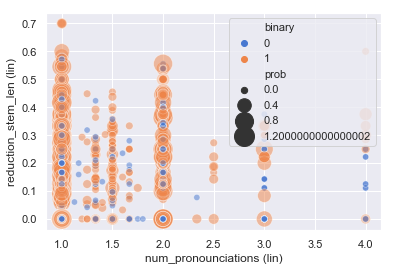

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = dataset_fc_linguistic[0].train
#data = data.loc[data.cal_ngram_2_sim_min>0.8,]

complexity_plot = sns.scatterplot(x="num_pronounciations (lin)", y="reduction_stem_len (lin)", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [ ]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/len-to-port-stem-steps.pdf')

# (3.3) Corpus-Based Features
Here we compute features which are based on larger corpora. In this category we distinguish e.g. between frequency counts and N-Gram Language Model probabilites.

### (1) Frequency

In [35]:
from nltk.stem.wordnet import *
from collections import defaultdict
from wordmodel import Word
import pandas as pd

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
word_freq_simple_wiki = {}
freq_sum_simple_wiki = 0
with open("resources/word-freq-dumps/simple_wiki_word_freqs.txt", encoding="ISO-8859-1") as file:
    for line in file:
        word, freq = line.split()
        word_freq_simple_wiki[word.strip()] = int(freq)
        freq_sum_simple_wiki+=int(freq)
        
word_freq_lang8 = {}
freq_sum_lang8 = 0
with open("resources/word-freq-dumps/word_freqs_lang8.txt", encoding="ISO-8859-1") as file:
    for line in file:
        word, freq = line.split()
        word_freq_lang8[word.strip()] = int(freq)
        freq_sum_lang8+=int(freq)

word_freq_bnc = {}
with open("resources/word-freq-dumps/bnc_freq_all.al", encoding="utf8") as file:
    for line in file:
        freq, word, pos, num_files = line.split()
        word_freq_bnc[word.strip()] = (int(freq), pos, int(num_files))

word_freq_bnc_lemma = {}
with open("resources/word-freq-dumps/bnc_lemma.al", encoding="utf8") as file:
    for line in file:
        sort_order, frequency, word, word_class = line.split()
        word_freq_bnc_lemma[word.strip()] = (int(sort_order), word_class, int(frequency))

        
word_pknown_nobs_prev_freqZipf = {}
with open("resources/word-freq-dumps/word_prevelance.csv", encoding="utf8") as file:
    for line in file:
        word, p_known, nobs, prevelance, freqZipf = line.split(";")
        word_pknown_nobs_prev_freqZipf[word.strip()] = (float(p_known.replace(',','.')), 
                                                        float(nobs.replace(',','.')), 
                                                        float(prevelance.replace(',','.')), 
                                                        float(freqZipf.replace(',','.')))
        
subtlex_us = {}
with open("resources/dictionaries/SUBTLEXus.txt", encoding="utf8") as file:
    for line in file:
        word, freq, cd_count, freq_low, cd_low, subtl_wf, lg10_wf, Subtlcd, lg10_cd = line.split('\t')
        subtlex_us[word.strip().lower()] = (int(freq), int(cd_count))
        
subtlex_uk = pd.read_csv("resources/dictionaries/SUBTLEXuk.txt", sep = "\t")
subtlex_uk_dict = dict(zip(subtlex_uk['Spelling'], subtlex_uk['CD_count']))

def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

def freqZipf(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[3] if stats else 3.5


WEIGHT_WIKI_SIMPLE_WIKI = freq_sum_wiki / freq_sum_simple_wiki
WEIGHT_WIKI_LANG_8 = freq_sum_wiki / freq_sum_lang8

def weighted_freq_ratio(target, word_freq_n, word_freq_m, weight):
    freq_n = word_freq_n.get(target.strip().lower(), 1)
    freq_m = word_freq_m.get(target.strip().lower(), 1)
    return -1 + (2 * (freq_n / ((freq_m * weight) + freq_n)))

C:\Users\Studio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
mwe_targets_train = list(set([mwe for ds in datasets for mwe in ds.train['target'].tolist()]))
mwe_targets_test = list(set([mwe for ds in datasets for mwe in ds.test['target'].tolist()]))
mwe_targets = mwe_targets_train.copy()
mwe_targets.extend(mwe_targets_test)
print('Len ta_train : {}'.format(len(mwe_targets_train)))
print('Len ta_test : {}'.format(len(mwe_targets_test)))
print('Len targets : {}'.format(len(mwe_targets)))

Len ta_train : 10716
Len ta_test : 2278
Len targets : 12994


In [37]:
import phrasefinder as pf

google_books_n_grams = {}
options = pf.SearchOptions()
options.topk = 10
n_grams = mwe_targets

with open('resources/word-freq-dumps/ngram_google.json', 'rb') as fp:
    google_books_n_grams = pickle.load(fp)

if not google_books_n_grams:
    for index, n_gram in enumerate(n_grams):
        try:
            print(index, n_gram)
            result = pf.search(pf.Corpus.AMERICAN_ENGLISH, n_gram, options)
            vals = [(phrase.match_count, phrase.volume_count, phrase.first_year, phrase.last_year)
                        for phrase in result.phrases]
            mean_vals = [np.sum(elem) / len(elem) for elem in zip(*vals)]
            google_books_n_grams[n_gram] = mean_vals
            if result.status != pf.Status.Ok:
                print('Request was not successful: {}'.format(result.status))
        except Exception as error:
            pass
    with open('resources/word-freq-dumps/ngram_google.json', 'wb') as fp:
        pickle.dump(google_books_n_grams, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
def features_frequency(dataframe, agg):   
    df = dataframe.copy()
    df['mrc_kf_freq (cor)'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.kf_freq, 0))
    df['mrc_kf_ncats (cor)'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.kf_ncats, 0))
    df['mrc_tl_freq (cor)'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.tl_freq, 0))
    df['mrc_brown_freq (cor)'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.brown_freq, 0))
    df['freq_wiki (cor)'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['log_freq_wiki (cor)'] = df['freq_wiki (cor)'].apply(lambda freq : np.log(freq))
    df['freq_simple_wiki (cor)'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_simple_wiki))
    df['log_freq_simple_wiki (cor)'] = df['freq_simple_wiki (cor)'].apply(lambda freq : np.log(freq))
    df['freq_bnc (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                    lambda target : word_freq_bnc.get(target)[0] if word_freq_bnc.get(target) else 0))
    df['log_freq_bnc (cor)'] = df['freq_bnc (cor)'].apply(lambda freq : np.log(freq))
    df['freq_bnc_lemma (cor)'] = df.p_lemma.apply(lambda target : agg(target, \
                    lambda target : word_freq_bnc_lemma.get(target)[2] \
                                         if word_freq_bnc_lemma.get(target) else 0))
    df['log_freq_bnc_lemma (cor)'] = df['freq_bnc_lemma (cor)'].apply(lambda freq : np.log(freq))
    df['freqZipf (cor)'] = df.p_target.apply(lambda target : agg(target, freqZipf))
    df['google_books_n_gram_freq (cor)'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[0] \
                                                     if google_books_n_grams.get(target) else 0)
    df['log_google_books_n_gram_freq (cor)'] = df['google_books_n_gram_freq (cor)'].apply(lambda freq : np.log(freq))
    df['google_books_n_gram_doc_freq (cor)'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[1] \
                                                        if google_books_n_grams.get(target)  else 0)
    df['log_google_books_n_gram_doc_freq (cor)'] = df['google_books_n_gram_doc_freq (cor)'].apply(lambda freq : np.log(freq))
    df['google_books_n_gram_first_year (cor)'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[2] \
                                                          if google_books_n_grams.get(target)  else 0)
    df['google_books_n_gram_last_year (cor)'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[3] \
                                                         if google_books_n_grams.get(target)  else 0)
    df['subtlex_cd_us (cor)'] = df.p_target.apply(lambda target : agg_feat_num_average(target, \
                    lambda target : subtlex_us[target.strip().lower()][1] if subtlex_us.get(target.strip().lower()) else 0))
    df['subtlex_cd_uk (cor)'] = df.p_target.apply(lambda target : agg_feat_num_average(target, \
                                    lambda target : subtlex_uk_dict.get(target, 0)))
    df['weighted_wiki_simple_wiki_ratio (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                    weighted_freq_ratio, word_freq_wiki, word_freq_simple_wiki, WEIGHT_WIKI_SIMPLE_WIKI))
    df['weighted_wiki_lang8_ratio (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                    weighted_freq_ratio, word_freq_wiki, word_freq_lang8, WEIGHT_WIKI_SIMPLE_WIKI))
    df = df.fillna(0)
    return df

fc_frequency = FeatureCategory('frequency', features_frequency)
feature_categories.append(fc_frequency)

In [39]:
dataset_fc_frequency = [FeatureDataset(ds.name, fc_frequency, agg,
                fc_frequency.func(ds.train, agg.agg), fc_frequency.func(ds.test, agg.agg)) for ds in datasets
                          for agg in aggs]

### (2) Language Model
Here we load the different Kneser-Ney n-gram models we trained previously.

In [40]:
import pickle

with open('resources/language-models/ngram_char_1.json', 'rb') as fp:
    ngram_char_1 = pickle.load(fp)
    
with open('resources/language-models/ngram_word_1.json', 'rb') as fp:
    ngram_word_1 = pickle.load(fp)

with open('resources/language-models/ngram_char_2.json', 'rb') as fp:
    ngram_char_2 = pickle.load(fp)
    
with open('resources/language-models/ngram_word_2.json', 'rb') as fp:
    ngram_word_2 = pickle.load(fp)
    
with open('resources/language-models/ngram_char_3.json', 'rb') as fp:
    ngram_char_3 = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_complex.json', 'rb') as fp:
    ngram_char_2_complex = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_non_complex.json', 'rb') as fp:
    ngram_char_2_non_complex = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_complex_cleaned.json', 'rb') as fp:
    ngram_char_2_complex_cleaned = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_non_complex_cleaned.json', 'rb') as fp:
    ngram_char_2_non_complex_cleaned = pickle.load(fp)
    
def kneser_ney_word_uni_gram(target):
    return ngram_word_1.cond_prob(target)

def kneser_ney_word_bi_gram(target):
    words = target.split()
    if len(words) <= 1:
        return ngram_word_2.cond_prob(target)
    return np.mean([ngram_word_2.cond_prob(words[index+1], (word,)) 
                for index, word in enumerate(words) 
                if index <= len(words)-2])
    
def kneser_ney_char_uni_gram_avg(target):
    return np.mean([ngram_char_1.cond_prob(character) 
            for character in target])

def kneser_ney_char_bi_gram_avg(target):
    return np.mean([ngram_char_2.cond_prob(target[index+1], (character,)) 
            for index, character in enumerate(target) if index <= len(target)-2])

def kneser_ney_char_bi_gram_avg_model(target, kn_model):
    return np.mean([kn_model.cond_prob(target[index+1], (character,)) 
            for index, character in enumerate(target) if index <= len(target)-2])

def kneser_ney_char_tri_gram_avg(target):
    return np.mean([ngram_char_3.cond_prob(target[index+2], (character, target[index+1])) 
            for index, character in enumerate(target) if index <= len(target)-3])

In [45]:
from nltk.stem.wordnet import *
wordNetLemmatizer = WordNetLemmatizer()

def features_language_model(dataframe, agg):
    df = dataframe.copy()
    df['kneser_ney_word_uni_gram (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_word_uni_gram))
    df['kneser_ney_word_bi_gram (cor)'] = df.p_target.apply(lambda target :  kneser_ney_word_bi_gram(target))
    df['kneser_ney_char_uni_gram_avg (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_uni_gram_avg))
    df['kneser_ney_char_bi_gram_avg (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg))
    df['kneser_ney_char_tri_gram_avg (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_tri_gram_avg))
    df['kneser_ney_char_bi_complex (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_complex))
    df['kneser_ney_char_bi_non_complex (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_non_complex))
    df['kneser_ney_char_bi_c_nc_ratio (cor)'] = df['kneser_ney_char_bi_complex (cor)'] / df['kneser_ney_char_bi_non_complex (cor)']
    df['kneser_ney_char_bi_complex_cl (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_complex_cleaned))
    df['kneser_ney_char_bi_non_complex_cl (cor)'] = df.p_target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_non_complex_cleaned))
    df['kneser_ney_char_bi_c_nc_ratio_cl (cor)'] = df['kneser_ney_char_bi_complex_cl (cor)'] / df['kneser_ney_char_bi_non_complex_cl (cor)']
    df = df.fillna(0)
    return df

fc_language_model = FeatureCategory('language_model', features_language_model)
feature_categories.append(fc_language_model)

In [46]:
dataset_fc_language_model = [FeatureDataset(ds.name, fc_language_model, agg,
                fc_language_model.func(ds.train, agg.agg), fc_language_model.func(ds.test, agg.agg)) for ds in datasets
                          for agg in aggs]

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [47]:
fc_corpus = FeatureCategory('corpus', [fc_frequency, fc_language_model])
dataset_fc_corpus = [FeatureDataset(ds.name, fc_corpus,  ds.agg,
            ds.train, ds.test) for ds in concat_feature_datasets(dataset_fc_frequency, dataset_fc_language_model)]

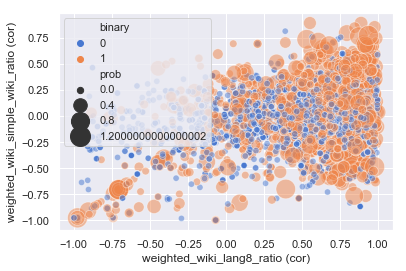

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = dataset_fc_corpus[0].train
data = data.loc[data['kneser_ney_char_bi_c_nc_ratio_cl (cor)']<1.2,]
#data['kneser20'] = data.kneser_ney_word_uni_gram * 10000
#data = data.loc[data.kneser20<10,]
complexity_plot_1 = sns.scatterplot(x="weighted_wiki_lang8_ratio (cor)", y="weighted_wiki_simple_wiki_ratio (cor)", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot_1)

In [83]:
figure = complexity_plot_1.get_figure()
figure.savefig('../plots/features/weighted-wiki-to-kn-bi-c-nc-cl.pdf')

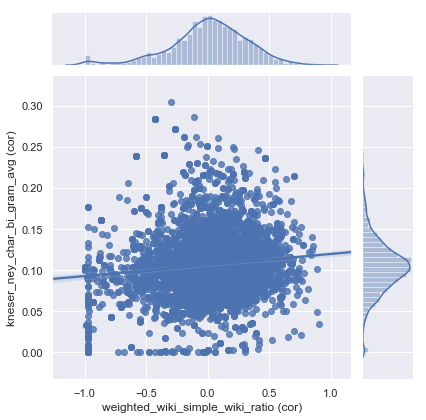

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = dataset_fc_corpus[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.jointplot(x="weighted_wiki_simple_wiki_ratio (cor)", y="kneser_ney_char_bi_gram_avg (cor)", data=data, kind="reg")
plt.show(complexity_plot)

In [51]:
concat_features = concat_feature_datasets(dataset_fc_linguistic, dataset_fc_corpus)

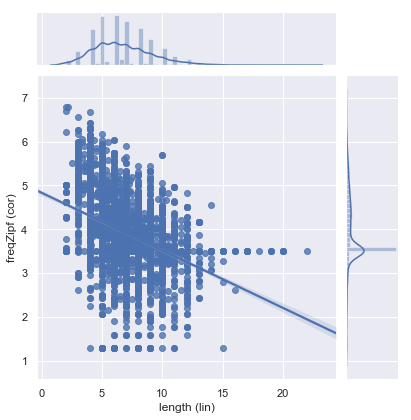

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.jointplot(x="length (lin)", y="freqZipf (cor)", data=data, kind="reg")
plt.show(complexity_plot)

# (3.4) Psycholinguistic Features based on MRC Database


In [53]:
from wordmodel import Word

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

word_concreteness = {}
with open("resources/word-freq-dumps/concreteness_brysbaert_et_al.txt", encoding="utf8") as file:
    for line in file:
        word, bigram, conc_m, conc_sd, \
        unknown, total, percent_known, \
        subtlex, dom_pos = line.split('\t')
        word_concreteness[word.strip()] = float(conc_m)
        
word_age_of_aquisition = {}
with open("resources/word-freq-dumps/AoA_ratings_Kuperman_et_al_BRM.csv", encoding="utf8") as file:
    for line in file:
        word, occur_total, occur_num, freq_pm, rating_Mean, rating_SD, dunno = line.split()
        word_age_of_aquisition[word.strip()] = float(rating_Mean.replace(',', '.')) if rating_Mean != 'NA' else 0

word_pknown_nobs_prev_freqZipf = {}
with open("resources/word-freq-dumps/word_prevelance.csv", encoding="utf8") as file:
    for line in file:
        word, p_known, nobs, prevelance, freqZipf = line.split(";")
        word_pknown_nobs_prev_freqZipf[word.strip()] = (float(p_known.replace(',','.')), 
                                                        float(nobs.replace(',','.')), 
                                                        float(prevelance.replace(',','.')), 
                                                        float(freqZipf.replace(',','.')))

def perc_known(target, missing_value):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[0] if stats else missing_value

def nobs(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[1] if stats else 0

def prevelance(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[2] if stats else 0

In [54]:
def features_psycholingusitic(dataframe, agg):
    df = dataframe.copy()
    df['mrc_fam (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.fam, 400))
    df['mrc_conc (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.conc, 400))
    df['mrc_imag (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.imag, 400))
    df['mrc_meanc (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.meanc, 400))
    df['mrc_meanp (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.meanp, 400))
    df['mrc_aoa (psy)'] = df.p_target.apply(lambda target : agg(target, mrc_database, lambda word : word.aoa, 3.5))
    df['perc_known (psy)'] = df.p_target.apply(lambda target : agg(target, perc_known, 0.5))
    df['nobs (psy)'] = df.p_target.apply(lambda target : agg(target, nobs))
    df['prevelance (psy)'] = df.p_target.apply(lambda target : agg(target, prevelance))
    df['concreteness (psy)'] = df.p_target.apply(lambda target : agg(target, \
                                                lambda target : word_concreteness.get(target, 2.5)))
    df['age_of_aquisition (psy)'] = df.p_target.apply(lambda target : agg(target, \
                                                    lambda target : word_age_of_aquisition.get(target, 8.5)))
    df = df.fillna(0)
    return df

fc_psycholinguistic = FeatureCategory('psycholinguistic', features_psycholingusitic)
feature_categories.append(fc_psycholinguistic)

In [55]:
dataset_fc_psycholinguistic = [FeatureDataset(ds.name, fc_psycholinguistic, agg,
                fc_psycholinguistic.func(ds.train, agg.agg), fc_psycholinguistic.func(ds.test, agg.agg)) for ds in datasets
                    for agg in aggs]

In [56]:
concat_features = concat_feature_datasets(dataset_fc_psycholinguistic, dataset_fc_linguistic)

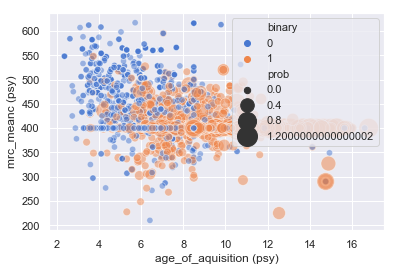

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="age_of_aquisition (psy)", y="mrc_meanc (psy)", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [61]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/aoa-mrc_meanc.pdf')

# (3.5) Semantic Features
Here we implement all the relevant features based on WordNet and SentiWordNet. For example, the number of synsets the target word is contained in or the average length of the lemmas of all the synsets the target word is contained in. Note that all features that are computed in the following exploit neither the POS-Tag of the target word nor Word Sense Disambiguation by e.g. UKB-Algorithm.

### (3.5.1) WordNet

In [58]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from nltk.stem.wordnet import *
from utils import penn_to_wn

wordNetLemmatizer = WordNetLemmatizer()

def wn_synset_freq(target):
    return len(wn.synsets(target))

def wn_synset_avg_lemma_freq(target):
    return np.nan_to_num(np.mean([len(synset.lemmas()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_lemma_len(target):
    return np.nan_to_num(np.nanmean([len(lemma.name()) 
            for synset in wn.synsets(target) 
            for lemma in synset.lemmas()]))

def wn_synset_avg_hypernyms(target):
    return np.nan_to_num(np.nanmean([len(synset.hypernyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_hyponyms(target):
    return np.nan_to_num(np.mean([len(synset.hyponyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_sum_hypernyms(target):
    return np.sum(([len(synset.hypernyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_definition_len(target):
    return np.nan_to_num(np.mean([len(str(synset.definition())) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_hyptree_depth(target):
    return np.nan_to_num(np.mean([synset.max_depth() 
            for synset in wn.synsets(target)]))

def wn_synset_num_distinct_pos(target):
    return len(set([synset.pos() for synset in wn.synsets(target)]))

def wn_synset_avg_num_relations(target):
    return np.nan_to_num(np.mean([np.sum([len(synset.hypernyms()), len(synset.hyponyms()), 
             len(synset.instance_hypernyms()), len(synset.instance_hyponyms()),
             len(synset.member_holonyms()), len(synset.substance_holonyms()),
             len(synset.part_holonyms()), len(synset.member_meronyms()),
             len(synset.substance_meronyms()), len(synset.part_meronyms())]) 
             for synset in wn.synsets(target)]))

def wn_synset_avg_freq_pos(target, pos):
    return len(wn.synsets(target, pos = pos))

def wn_synset_pos_ratio_1(target, pos):
    tokens = word_tokenize(target)
    ratios = []
    for token, poss in zip(tokens, pos):
        synsets_freqs = len(wn.synsets(token))
        ratios.append(len(wn.synsets(token, pos = poss)) / synsets_freqs \
                if synsets_freqs != 0 else 0.25)
    return np.mean(ratios)

def wn_synset_pos_ratio_2(target, pos):
    tokens = word_tokenize(target)
    ratios = []
    for token, poss in zip(tokens, pos):
        synsets_counts = np.sum([lemma.count() 
                for sn in wn.synsets(token) for lemma in sn.lemmas()])
        ratios.append(np.sum([lemma.count() for sn in wn.synsets(token, pos = poss) 
                    for lemma in sn.lemmas()]) / synsets_counts if synsets_counts != 0 else 0.25)
    return np.mean(ratios)

def wn_synset_sense_entropy_uniform(target):
    num_senses = len(wn.synsets(target))
    return -np.sum([((1 / num_senses) * np.log2(1 / num_senses)) 
                     for index in range(0, num_senses)])

def wn_synset_sense_entropy_pos_uniform(target):
    num_senses = len(wn.synsets(target))
    pos_distribution = [len(wn.synsets(target, pos = wn.NOUN)),
                        len(wn.synsets(target, pos = wn.VERB)),
                        len(wn.synsets(target, pos = wn.ADJ)),
                        len(wn.synsets(target, pos = wn.ADV))]
    return -np.sum([(np.nan_to_num((count / num_senses) * np.log2(count / num_senses))) 
            for count in pos_distribution]) if num_senses != 0 else 0

def wn_synsets_sense_entropy_pos_central(target, pos):
    num_senses_pos = len(wn.synsets(target, pos = pos))
    return -np.sum([((1 / num_senses_pos) * np.log2(1 / num_senses_pos))
                     for index in range(0, num_senses_pos)])

def wn_synset_pos_probability_1(target, pos):
    synsets = wn.synsets(target)
    syn_freq_other_pos = np.sum([1 for synset in synsets if synset.pos() != pos])
    return len(wn.synsets(target, pos = pos)) / syn_freq_other_pos

def wn_synsets_avg_lemma_freq(target, freqs_func, freqs):
    synsets = wn.synsets(target)
    if not synsets:
        return 0
    return np.mean([np.nan_to_num(freqs_func(lemma.name(), freqs)) for synset in synsets
                    for lemma in synset.lemmas()])

def wn_synsets_freq_ratio_to_max_agg_min(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq

def wn_synsets_freq_ratio_to_max_agg_mean(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.mean([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq

def wn_synsets_freq_ratio_to_max_agg_median(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.median([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq
    
def swn_avg_objective_score(target):
    return np.nan_to_num(np.mean([senti_synset.obj_score() 
                for senti_synset in swn.senti_synsets(target)]))

def wn_synset_lesk_wsd_ratio_hi_freq(target, sentence, freqs_func, freqs, pos):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq > target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_hi_freq_sum(target, sentence, freqs_func, freqs, pos):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([freq for freq in freqis if freq > target_freq]) / np.sum(freqis)

def wn_synset_lesk_wsd_ratio_hi_nopos_freq(target, sentence, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq > target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_low_freq(target, sentence, freqs_func, freqs, pos):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq < target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_low_freq_sum(target, sentence, freqs_func, freqs, pos):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([freq for freq in freqis if freq < target_freq]) / np.sum(freqis)

def wn_synset_lesk_wsd_ratio_low_nopos_freq(target, sentence, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq < target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_to_freq_sum(target, sentence, freqs_func, freqs, pos):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return target_freq / np.sum(freqis)

def wn_synset_lesk_wsd__norm_sense_rank(target, sentence, freqs_func, freqs, wsd_func, pos):
    wsd_synset = wsd_func(sentence.split(), target, pos)
    senses = wn.synsets(target)
    if not wsd_synset:
        return 0
    wsd_synset = lesk(sentence.split(), target, pos)
    sense_freqs = sorted([(sense, np.sum([lemma.count() for lemma in sense.lemmas()])) 
                   for sense in senses], key = lambda tpl : tpl[1], reverse=True)
    sense_index = [sense for sense, cnt in sense_freqs].index(wsd_synset)
    return sense_index / len(senses)

In [59]:
from nltk.wsd import lesk
from pywsd.lesk import adapted_lesk

def features_wordnet(dataframe, agg):
    df = dataframe.copy()
    df['wn_synset_freq (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_freq))
    df['wn_synset_avg_lemma_freq (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_avg_lemma_freq))
    df['wn_synset_avg_lemma_len (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_avg_lemma_len))
    
    df['length'] = df.target.apply(lambda target : agg(target, len))
    df['wn_synset_diff_len_avg_lemma_len (sem)'] = df['wn_synset_avg_lemma_len (sem)'] - df.length
    df['wn_synset_avg_hypernyms (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_avg_hypernyms))
    df['wn_synset_sum_hypernyms (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_sum_hypernyms))
    df['wn_synset_avg_hyponyms (sem)'] = df.p_target.apply(lambda target : agg(target, wn_synset_avg_hyponyms))

    df['wn_synset_avg_definition_len (sem)'] = df.p_target.apply(lambda target : 
                                                         agg(target, wn_synset_avg_definition_len))
    df['wn_synset_avg_hyptree_depth (sem)'] = df.p_target.apply(lambda target :
                                                         agg(target, wn_synset_avg_hyptree_depth))
    df['wn_synset_num_distinct_pos (sem)'] = df.p_target.apply(lambda target : 
                                                         agg(target, wn_synset_num_distinct_pos))
    df['wn_synset_avg_num_relations (sem)'] = df.p_target.apply(lambda target : 
                                                         agg(target, wn_synset_avg_num_relations))

    df['wn_synset_avg_freq_pos_noun (sem)'] = df.p_target.apply(lambda target : 
                                                        agg(target, wn_synset_avg_freq_pos, wn.NOUN))
    df['wn_synset_avg_freq_pos_verb (sem)'] = df.p_target.apply(lambda target : 
                                                        agg(target, wn_synset_avg_freq_pos, wn.VERB))
    df['wn_synset_avg_freq_pos_adj (sem)'] = df.p_target.apply(lambda target : 
                                                       agg(target, wn_synset_avg_freq_pos, wn.ADJ))
    df['wn_synset_avg_freq_pos_adv (sem)'] = df.p_target.apply(lambda target : 
                                                       agg(target, wn_synset_avg_freq_pos, wn.ADV))

    df['wn_synset_avg_freq_pos_noun_norm (sem)'] = np.nan_to_num(df['wn_synset_avg_freq_pos_noun (sem)'] / \
                                                                 df['wn_synset_freq (sem)'])
    df['wn_synset_avg_freq_pos_verb_norm (sem)'] = np.nan_to_num(df['wn_synset_avg_freq_pos_verb (sem)'] / \
                                                                 df['wn_synset_freq (sem)'])
    df['wn_synset_avg_freq_pos_adj_norm (sem)'] = np.nan_to_num(df['wn_synset_avg_freq_pos_adj (sem)'] / \
                                                                df['wn_synset_freq (sem)'])
    df['wn_synset_avg_freq_pos_adv_norm (sem)'] = np.nan_to_num(df['wn_synset_avg_freq_pos_adv (sem)'] / \
                                                                df['wn_synset_freq (sem)'])

    df['wn_synset_sense_entropy_uniform (sem)'] = df.p_target.apply(lambda target : 
                                            agg(target, wn_synset_sense_entropy_uniform))
    df['wn_synset_sense_entropy_pos_uniform (sem)'] = df.p_target.apply(lambda target :
                                            agg(target, wn_synset_sense_entropy_pos_uniform))
    df['wn_synsets_sense_entropy_pos_central (sem)'] = df[['p_target', 'pos_tags_pt']].apply(
        lambda vals : wn_synsets_sense_entropy_pos_central(vals[0], vals[1]), axis = 1)
    
    df['wn_synset_pos_ratio_1 (sem)'] = df[['p_target', 'pos_tags_pt']].apply(
                    lambda vals : wn_synset_pos_ratio_1(vals[0], vals[1]), axis = 1)
    
    df['wn_synset_pos_ratio_2 (sem)'] = df[['p_target', 'pos_tags_pt']].apply(
                    lambda vals : wn_synset_pos_ratio_2(vals[0], vals[1]), axis = 1)

    df['swn_avg_objective_score (sem)'] = df.p_target.apply(lambda target : agg(target, swn_avg_objective_score))

    df['wn_synsets_freq_ratio_to_max_agg_min (sem)'] = df.p_target.apply(lambda target : \
                                                    agg(target, wn_synsets_freq_ratio_to_max_agg_min, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_max_agg_mean (sem)'] = df.p_target.apply(lambda target : \
                                                    agg(target, wn_synsets_freq_ratio_to_max_agg_mean, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_max_agg_median (sem)'] = df.p_target.apply(lambda target : \
                                                    agg(target, wn_synsets_freq_ratio_to_max_agg_median, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_avg_lemma_freq (sem)'] = df.p_target.apply(lambda target : \
                                                    agg(target, wn_synsets_avg_lemma_freq, \
                                                                         get_dict_count, word_freq_wiki))
    df['freq_wiki'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_avg (sem)'] = df['wn_synsets_avg_lemma_freq (sem)'] / df.freq_wiki
    df['wn_synset_lesk_wsd_ratio_hi_freq (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_hi_freq, vals[1], \
                                     get_dict_count, word_freq_wiki, pos=vals[2]), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_freq (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_low_freq, vals[1], \
                                     get_dict_count, word_freq_wiki, pos=vals[2]), axis = 1)
    df['wn_synset_lesk_wsd_ratio_hi_nopos_freq (sem)'] = df[['p_target','sentence']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_hi_nopos_freq, vals[1], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_nopos_freq (sem)'] = df[['p_target','sentence']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_low_nopos_freq, vals[1], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_hi_freq_sum (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_hi_freq_sum, vals[1], \
                                     get_dict_count, word_freq_wiki, pos=vals[2]), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_freq_sum (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_low_freq_sum, vals[1], \
                                     get_dict_count, word_freq_wiki, pos=vals[2]), axis = 1)
    df['wn_synset_lesk_wsd_ratio_to_freq_sum (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_to_freq_sum, vals[1], \
                                     get_dict_count, word_freq_wiki, pos=vals[2]), axis = 1)
    df['wn_synset_lesk_wsd__norm_sense_rank (sem)'] = df[['p_target','sentence', 'pos_tags_pt']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd__norm_sense_rank, vals[1], \
                                     get_dict_count, word_freq_wiki, lesk, pos=vals[2]), axis = 1)
    df = df.drop(['length', 'freq_wiki'], axis = 1)
    df = df.fillna(0)
    return df

fc_wordnet = FeatureCategory('wordnet', features_wordnet)
feature_categories.append(fc_wordnet)

Warming up PyWSD (takes ~10 secs)... took 5.456312417984009 secs.


In [60]:
dataset_fc_wordnet = [FeatureDataset(ds.name, fc_wordnet, agg,
                fc_wordnet.func(ds.train, agg.agg), fc_wordnet.func(ds.test, agg.agg)) for ds in datasets
                      for agg in aggs]

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:202: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:226: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:202: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in

In [63]:
concat_features = concat_feature_datasets(dataset_fc_wordnet, dataset_fc_linguistic,
                                          dataset_fc_psycholinguistic)

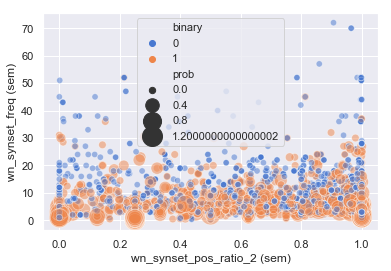

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="wn_synset_pos_ratio_2 (sem)", y="wn_synset_freq (sem)", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [ ]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/syn-freq-to-avg-def-len.pdf')

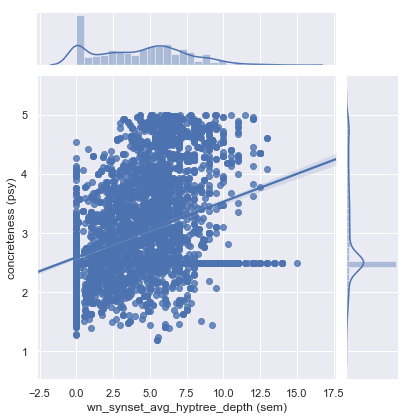

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.jointplot(x="wn_synset_avg_hyptree_depth (sem)", y="concreteness (psy)", data=data, kind="reg")
plt.show(complexity_plot)

In [ ]:
complexity_plot.savefig('../plots/features/wn-hyp-depth-to-conc.pdf')

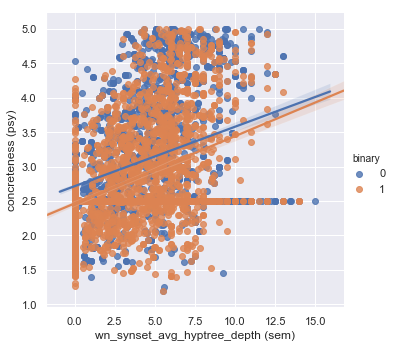

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.lmplot(x="wn_synset_avg_hyptree_depth (sem)", y="concreteness (psy)", hue='binary', data=data)
plt.show(complexity_plot)

In [ ]:
complexity_plot.savefig('../plots/features/wn-hyp-depth-to-conc-2.pdf')

### (3.5.2) DBpedia

In [67]:
import spotlight
from joblib import Memory

memory = Memory(location='resources/dbpedia-cache', verbose=0)
@memory.cache
def annotate_dbpedia_spotlight(sentence, confidence=0.0, support=20):
    return spotlight.annotate('https://api.dbpedia-spotlight.org/en/annotate',
                                sentence, confidence=confidence, support=support)

In [68]:
sentences_train = list(set([sentence for ds in datasets for sentence in ds.train['sentence'].unique().tolist()]))
sentences_test = list(set([sentence for ds in datasets for sentence in ds.test['sentence'].unique().tolist()]))
sentences = sentences_train.copy()
sentences.extend(sentences_test)
print('Len ta_train : {}'.format(len(sentences_train)))
print('Len ta_test : {}'.format(len(sentences_test)))
print('Len targets : {}'.format(len(sentences)))

Len ta_train : 1988
Len ta_test : 266
Len targets : 2254


In [ ]:
import time

sents_dbpedia_75 = {}
sent_no_annotation = []
for index, sentence in enumerate(sentences):
    print('{} : {}'.format(index, sentence))
    if(index % 100 == 0):
        print('----------Sleeping----------')
        time.sleep(60)
    try:
        sents_dbpedia_75[sentence] = annotate_dbpedia_spotlight(sentence, confidence = 0.75)
    except:
        sent_no_annotation.append(sentence)

In [69]:
import pickle

with open('resources/dbpedia-cache/dbpedia_annotations_00.json', 'rb') as fp:
    dbpedia_00 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_25.json', 'rb') as fp:
    dbpedia_25 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_50.json', 'rb') as fp:
    dbpedia_50 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_75.json', 'rb') as fp:
    dbpedia_75 = pickle.load(fp)
    
with open('resources/dbpedia-cache/pagerank.json', 'rb') as fp:
        page_rank = pickle.load(fp)

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
import time

exceptions = []
page_rank = {}
for index, uri in enumerate(uris):
    try:
        print('{} : {}'.format(index, uri))
        if(index % 200 == 0):
            print('----------Sleeping----------')
            time.sleep(60)
        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        sparql.setQuery("""
            PREFIX rdf:<http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            PREFIX vrank:<http://purl.org/voc/vrank#>
            PREFIX dbo:<http://dbpedia.org/ontology/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            SELECT distinct ?v
            FROM <http://dbpedia.org>
            FROM <http://people.aifb.kit.edu/ath/#DBpedia_PageRank>
            WHERE {
                <"""+ uri +"""> vrank:hasRank/vrank:rankValue ?v.
            }
        """)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            page_rank[uri] = float(result['v']['value'])
    except Exception as e:
        exceptions.append(str(e))

In [70]:
def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def dbp_match_entities(sentence, target, start, end, annotations):
    an_sents = annotations.get(sentence)
    if an_sents:
        ans = [(an['offset'], an['offset']+len(an['surfaceForm']), an) for an in an_sents]
        return [an for s, e, an in ans if overlaps(start, end, s, e)]
    return []

def dbp_entity_ratio(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.min([np.sum([len(entity['surfaceForm']) 
                for entity in entities]) / len(target), 1])
    return 0

def dbp_support(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.mean([entity['support'] for entity in entities])
    return 0

def dbp_type_hierachy_depth(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.mean([np.sum([1 for cat in entity['types'].split(',') if 'DBpedia' in cat])
                 for entity in entities])
    return 0

def dbp_freq_types(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.mean([len(entity['types'].split(',')) for entity in entities])
    return 0

def dbp_confidence(sentence, target, start, end):
    entities = dbp_match_entities(sentence, target, start, end, dbpedia_75)
    if entities:
        return 0.75
    entities = dbp_match_entities(sentence, target, start, end, dbpedia_50)
    if entities:
        return 0.5
    entities = dbp_match_entities(sentence, target, start, end, dbpedia_25)
    if entities:
        return 0.25
    return 0

def dbp_pagerank(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    return np.nan_to_num(np.mean([page_rank.get(entity['URI'], 0) for entity in entities]))

dbp_types = [('DBpedia:Place', 1, 'dbo:Place'), ('DBpedia:Person',2, 'dbo:Person'), 
             ('DBpedia:Organisation',3, 'dbo:Organisation'), ('DBpedia:Timeperiod', 4, 'dbo:Timeperiod')]

def dbp_extract_type(entity):
    types = [(cat, rank, name) for cat, rank, name in dbp_types if cat in entity['types']]
    if not types and not entity['types']:
        return ('dbo:notype', 0, 'dbo:notype')
    if not types and entity['types']:
        return ('dbo:misc', 5, 'dbo:misc')
    else:
        return types[0]

def dbp_type(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if not entities:
        return 'dbo:missing'
    types = [dbp_extract_type(entity) for entity in entities]
    sorted(types, key=lambda tpl : tpl[1])
    return types[0][2]

In [71]:
train = datasets[0].train
df_tester = train.loc[train.sentence==sentences[2],]

def features_dbpedia(dataframe, agg):
    df = dataframe.copy()
    df['dbp_confidence (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_confidence(*vals),axis = 1)
    
    df['dbp_entity_ratio_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_entity_ratio(*vals, dbpedia_25),axis = 1)
    df['dbp_entity_support_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_support(*vals, dbpedia_25),axis = 1)
    df['dbp_type_hierachy_depth_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_type_hierachy_depth(*vals, dbpedia_25),axis = 1)
    df['dbp_freq_types_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_freq_types(*vals, dbpedia_25),axis = 1)
    df['dbp_pagerank_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_pagerank(*vals, dbpedia_25),axis = 1)
    max_page_rank = np.max(df['dbp_pagerank_25 (sem)'])
    df['dbp_norm_pagerank_25 (sem)'] = df['dbp_pagerank_25 (sem)'] / max_page_rank
    df['dbp_type_25 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_type(*vals, dbpedia_25),axis = 1)
    
    df['dbp_entity_ratio_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_entity_ratio(*vals, dbpedia_00),axis = 1)
    df['dbp_entity_support_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_support(*vals, dbpedia_00),axis = 1)
    df['dbp_type_hierachy_depth_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_type_hierachy_depth(*vals, dbpedia_00),axis = 1)
    df['dbp_freq_types_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_freq_types(*vals, dbpedia_00),axis = 1)
    df['dbp_pagerank_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_pagerank(*vals, dbpedia_00),axis = 1)
    max_page_rank = np.max(df['dbp_pagerank_00 (sem)'])
    df['dbp_norm_pagerank_00 (sem)'] = df['dbp_pagerank_00 (sem)'] / max_page_rank
    df['dbp_type_00 (sem)'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_type(*vals, dbpedia_00),axis = 1)
    
    df = df.fillna(0)
    return df

fc_dbpedia = FeatureCategory('dbpedia', features_dbpedia)
feature_categories.append(fc_dbpedia)

In [72]:
dataset_fc_dbpedia = [FeatureDataset(ds.name, fc_dbpedia, agg,
                fc_dbpedia.func(ds.train, agg.agg), fc_dbpedia.func(ds.test, agg.agg)) for ds in datasets
                     for agg in aggs]

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [73]:
concat_features = concat_feature_datasets(dataset_fc_dbpedia, dataset_fc_linguistic,
                                          dataset_fc_psycholinguistic)

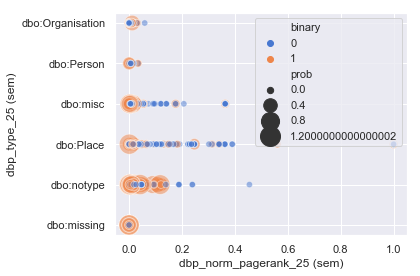

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="dbp_norm_pagerank_25 (sem)", y="dbp_type_25 (sem)", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
complexity_plot.legend(scatterpoints=1)
plt.tight_layout()
plt.show(complexity_plot)

In [ ]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/dbp-rank-to-freq-types.pdf')

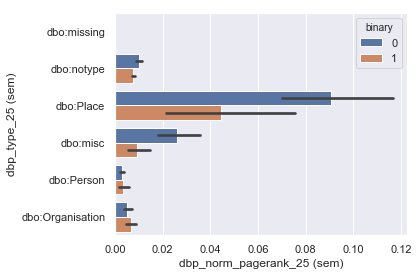

In [75]:
model_plot = sns.barplot(x="dbp_norm_pagerank_25 (sem)", y="dbp_type_25 (sem)", hue="binary", data=data)
plt.tight_layout()
plt.show(model_plot)

In [179]:
figure = model_plot.get_figure()
figure.savefig('../plots/features/dbp-rank-to-freq-types-bar.pdf')

## (3.5.3) Brown Clustering

In [76]:
brown_cluster_word2cluster = {}
brown_cluster_cluster2words = defaultdict(list)
with open("resources/brown-clustering/paths/rcv1.clean-c6000-p1.paths", encoding="utf8") as file:
    for line in file:
        binary_cluster, word, _ = line.split()
        brown_cluster_word2cluster[word] = binary_cluster
        brown_cluster_cluster2words[binary_cluster].append(word)

def brown_clustering_cluster_size(target):
    cluster = brown_cluster_word2cluster.get(target)
    return len(brown_cluster_cluster2words[cluster]) if cluster else 0

def brown_clustering_cluster_depth_simple(target):
    cluster = brown_cluster_word2cluster.get(target)
    return int(cluster, 2) if cluster else 0

def brown_clustering_cluster_depth_bit(target):
    cluster = brown_cluster_word2cluster.get(target)
    if not cluster:
        return 8.75
    return np.sum([1 for bit in cluster if bit == '1'])

def brown_clustering_cluster_size_all(target):
    cluster = brown_cluster_word2cluster.get(target)
    if not cluster:
        return 0
    upper_clusters = [cluster[0:(len(cluster) - index)] + '0' * index \
         for index, bit in enumerate(reversed(cluster)) if bit == '1']
    cluster_counts = [len(brown_cluster_cluster2words.get(clu, [])) \
                         for clu in upper_clusters]
    return np.sum(cluster_counts)

In [77]:
def features_brown_clustering(dataframe, agg):
    df = dataframe.copy()
    df['brown_clustering_cluster_size (sem)'] = df.p_target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_size))
    df['brown_clustering_cluster_size_all (sem)'] = df.p_target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_size_all))
    df['brown_clustering_cluster_depth_simple (sem)'] = df.p_target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_depth_simple))
    df['brown_clustering_cluster_depth_bit (sem)'] = df.p_target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_depth_bit))
    df = df.fillna(0)
    return df

fc_brown_clustering = FeatureCategory('brown_clustering', features_brown_clustering)
feature_categories.append(fc_brown_clustering)

In [78]:
dataset_fc_brown_clustering = [FeatureDataset(ds.name, fc_brown_clustering, agg,
                fc_brown_clustering.func(ds.train, agg.agg), fc_brown_clustering.func(ds.test, agg.agg)) for ds in datasets
                     for agg in aggs]

In [79]:
concat_features = concat_feature_datasets(dataset_fc_brown_clustering, dataset_fc_linguistic,
                                          dataset_fc_psycholinguistic)

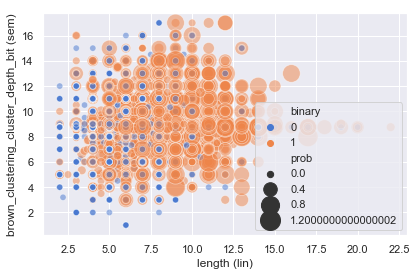

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="length (lin)", y="brown_clustering_cluster_depth_bit (sem)", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
complexity_plot.legend(scatterpoints=1)
plt.tight_layout()
plt.show(complexity_plot)

In [65]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/brown-cluster-depth-length.pdf')

In [81]:
fc_semantic = FeatureCategory('semantic', [fc_wordnet, fc_dbpedia, fc_brown_clustering])
dataset_fc_semantic = [FeatureDataset(ds.name, fc_semantic,  ds.agg,
            ds.train, ds.test) for ds in concat_feature_datasets(dataset_fc_wordnet,
                                   dataset_fc_brown_clustering)]

# (3.6) Dictionary Features


In [82]:
import textatistic
from collections import Counter

academic_words = {}
with open("resources/dictionaries/academic_word_list.txt", encoding="utf8") as file:
    for line in file:
        word, rank = line.split()
        academic_words[word.strip()] = rank

prefixes = {}
with open("resources/dictionaries/prefixes.txt", encoding="utf8") as file:
    for line in file:
        prefix, definition, examples = line.split('\t')
        prefixes[prefix.replace('-', '').strip()] = definition

suffixes = {}
with open("resources/dictionaries/suffixes.txt", encoding="utf8") as file:
    for line in file:
        suffix, definition, examples = line.split('\t')
        suffixes[suffix.replace('-', '').strip()] = definition

with open("resources/dictionaries/biology_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_biology = set(content)

with open("resources/dictionaries/geography_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_geography = set(content)
    
with open("resources/dictionaries/physics_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_physics = set(content)
    
with open("resources/dictionaries/stopwords_en.txt", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    stop_words = set(content)
    
with open("resources/dictionaries/most_freq_used_3000_words.txt", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    most_freq_used_3000_words = set(content)
    
with open("resources/dictionaries/most_freq_used_5000_words.txt", encoding="utf8") as file:
    content = [line.split()[1].strip().lower() for line in file.readlines()]
    most_freq_used_5000_words = set(content)
    

'''
Extract all words that are exactly identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are neglected for the vocabulary
'''
def build_clean_vocabulary(train):
    targets_complex = set([mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()])
    targets_non_complex = set([mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()])
    targets_complex_cleaned = list(targets_complex.difference(targets_non_complex))
    targets_non_complex_cleaned = list(targets_non_complex.difference(targets_complex))
    vocabulary = {}
    for target in targets_complex_cleaned:
        vocabulary[target] = 1
    for target in targets_non_complex_cleaned:
        vocabulary[target] = 0
    return vocabulary

'''
Extract all words that are identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are weighted based on the number
of occurrences. If the word has been tagged more times as non-complex
we save it as non-complex otherwise it is complex
'''
def build_weighted_vocabulary(train):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_1(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] < confidence,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_2(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_mean(train):
    train['target'] = train.target.apply(lambda target : target.strip().lower())
    agg = train[['target', 'prob']].groupby('target',
                        as_index=False).mean().values
    tuples = [tuple(val) for val in agg]
    vocabulary = {}
    for target, confidence in tuples:
        vocabulary[target] = confidence
    return vocabulary

def build_confidence_vocabulary_max(train):
    train['target'] = train.target.apply(lambda target : target.strip().lower())
    agg = train[['target', 'prob']].groupby('target',
                        as_index=False).max().values
    tuples = [tuple(val) for val in agg]
    vocabulary = {}
    for target, confidence in tuples:
        vocabulary[target] = confidence
    return vocabulary

In [83]:
def features_dictionary(dataframe, agg):
    df = dataframe.copy()
    df['dict_dale_chall (dic)'] = df.p_target.apply(lambda target : agg(target, \
                            lambda target :  0 if textatistic.notdalechall_count(target) >= 1 else 1))
    df['dict_570_academic_words (dic)'] = df.p_target.apply(lambda target : agg(target, \
                                                    lambda target : int(target in academic_words)))
    df['common_prefix (dic)'] = df.p_target.apply(lambda target : int(np.sum([1 for prefix in prefixes if target.startswith(prefix)]) > 0))
    df['common_suffix (dic)'] = df.p_target.apply(lambda target : int(np.sum([1 for suffix in suffixes if target.endswith(suffix)]) > 0))
    df['gloss_biology (dic)'] = df.p_target.apply(lambda target : int(target in gloss_biology))
    df['gloss_physics (dic)'] = df.p_target.apply(lambda target : int(target in gloss_physics))
    df['gloss_geography (dic)'] = df.p_target.apply(lambda target : int(target in gloss_geography))
    df['stop_word (dic)'] = df.p_target.apply(lambda target : int(target in stop_words))
    df['most_freq_used_3000_words (dic)'] = df.p_target.apply(lambda target : agg(target, \
                                                    lambda target : int(target in most_freq_used_3000_words)))
    df['most_freq_used_5000_words (dic)'] = df.p_target.apply(lambda target : agg(target, \
                                                    lambda target : int(target in most_freq_used_5000_words)))
    df = df.fillna(0)
    return df

fc_dictionary = FeatureCategory('dictionary', features_dictionary)
feature_categories.append(fc_dictionary)

In [84]:
dataset_fc_dictionary = [FeatureDataset(ds.name, fc_dictionary, agg,
                fc_dictionary.func(ds.train, agg.agg), fc_dictionary.func(ds.test, agg.agg)) for ds in datasets
                        for agg in aggs]

In [85]:
concat_features = concat_feature_datasets(dataset_fc_semantic, dataset_fc_linguistic,
                dataset_fc_psycholinguistic, dataset_fc_corpus, dataset_fc_dictionary)

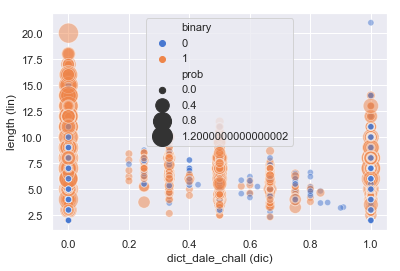

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[2].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="dict_dale_chall (dic)", y="length (lin)", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [172]:
complexity_plot_figure = complexity_plot.get_figure()
complexity_plot_figure.savefig('../plots/features/len-to-dale-chall.pdf')

# Classification Analysis
Here we compute individual feature importance based on different metrics. For example, we implement and compute the F-Score, providing an idea of the discrimination power the feature has.

In [87]:
from collections import namedtuple
Result = namedtuple('Result', 'dataset, fc, agg, measure')
Dataset = namedtuple('Dataset', 'name, train, test')
FeatureDataset = namedtuple('FeatureDataset', 'name, fc, agg, train, test')
FeatureCategory = namedtuple('FeatureCategory', 'name, func')
Feature = namedtuple('Feature', 'name, fc_name, train, test')
Metric = namedtuple('Metric', 'name, func')

### (1) Utility Functions

In [88]:
def remove_labels_for_binary_df(dataframe, drop=[]):
    drop_list = ['id', 'sentence', 'target', 'nat', 'non_nat', 
                  'nat_marked', 'non_nat_marked', 'prob', 'start', 
                  'end', 'p_target', 'lemma', 'p_lemma', 'pos_tags', 'pos_tags_pt']
    drop_list.extend(drop)
    df = dataframe.copy()
    df = df.drop(drop_list, axis = 1)
    return df

def remove_labels_for_regr_df(dataframe, drop=[]):
    drop_list = ['id', 'sentence', 'target', 'nat', 'non_nat', 
                  'nat_marked', 'non_nat_marked', 'binary', 'start', 
                  'end', 'p_target', 'lemma', 'p_lemma', 'pos_tags', 'pos_tags_pt']
    drop_list.extend(drop)
    df = dataframe.copy()
    df = df.drop(drop_list, axis = 1)
    return df
    
def transform_feat_to_num(train, test):
    train_copy = train.copy()
    test_copy = test.copy()
    #train_copy = train_copy.replace(np.inf, 0)
    #train_copy = train_copy.replace(np.nan, 0)
    train_copy = train_copy.replace([np.inf, -np.inf], np.nan)
    train_copy = train_copy.fillna(0)
    #test_copy = test_copy.replace(np.inf, 0)
    #test_copy = test_copy.replace(np.nan, 0)
    test_copy = test_copy.replace([np.inf, -np.inf], np.nan)
    test_copy = test_copy.fillna(0)
    shape_train = train.shape
    shape_test = test.shape
    df = train_copy.append(test_copy, ignore_index=True)
    print(df)
    df = pd.get_dummies(df)
    print(df)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    df = df.applymap(lambda x: 1 if x == True else x)
    df = df.applymap(lambda x: 0 if x == False else x)
    return (df.loc[0:(shape_train[0]-1),], 
            df.loc[shape_train[0]:df.shape[0],])

### (2.1) Baseline Always Complex

In [61]:
from collections import Counter

results = [Result(ds.name, 'always_complex', agg_default[0],
    always_complex_prediction(remove_labels_for_binary_df(ds.train), 
        remove_labels_for_binary_df(ds.test))) for ds in datasets]
evaluation = [{'dataset' : result.dataset, 
                    'zc' : result.fc, 'prec' : result.measure[0][1],
              'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                   for result in results]
counts = [(ds.name, Counter(ds.test.binary)) for ds in datasets]
feature_eval_data = pd.DataFrame.from_records(evaluation)
print(counts)
feature_eval_data

[('Wikipedia', Counter({0: 355, 1: 339})), ('WikiNews', Counter({0: 517, 1: 353})), ('News', Counter({0: 1068, 1: 696}))]


C:\Users\Studio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Studio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Studio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


dataset        f1      prec  rec              zc
0  Wikipedia  0.656341  0.488473  1.0  always_complex
1   WikiNews  0.577269  0.405747  1.0  always_complex
2       News  0.565854  0.394558  1.0  always_complex

### (2.2) Baseline Memorize Vocabulary

In [62]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support

'''
Extract all words that are exactly identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are neglected for the vocabulary
'''
def build_clean_vocabulary(train):
    targets_complex = set([mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()])
    targets_non_complex = set([mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()])
    targets_complex_cleaned = list(targets_complex.difference(targets_non_complex))
    targets_non_complex_cleaned = list(targets_non_complex.difference(targets_complex))
    vocabulary = {}
    for target in targets_complex_cleaned:
        vocabulary[target] = 1
    for target in targets_non_complex_cleaned:
        vocabulary[target] = 0
    return vocabulary

'''
Extract all words that are identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are weighted based on the number
of occurrences. If the word has been tagged more times as non-complex
we save it as non-complex otherwise it is complex
'''
def build_weighted_vocabulary(train):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_1(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] < confidence,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_2(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary
    

def evaluate_label_target_predictions(test, vocabulary):
    dict_test = list(zip(test.target, test.binary))
    data = [(binary, (vocabulary[target.strip().lower()] if target.strip().lower() in vocabulary else 1)) 
            for target, binary in dict_test]
    y_true = [vals[0] for vals in data]
    prediction = [vals[1] for vals in data]
    return precision_recall_fscore_support(y_true, prediction)

evaluation_clean = [Result(ds.name, 'vocab_clean', agg_default[0], 
                    evaluate_label_target_predictions(ds.test, 
                    build_clean_vocabulary(ds.train))) for ds in datasets]
evaluation_weighted = [Result(ds.name, 'vocab_weighted', agg_default[0], 
                        evaluate_label_target_predictions(ds.test, 
                    build_weighted_vocabulary(ds.train))) for ds in datasets]
evaluation_conf = [Result(ds.name, 'vocab_conf', agg_default[0], 
                        evaluate_label_target_predictions(ds.test, 
                    build_confidence_vocabulary_2(ds.train, 0.5))) for ds in datasets]

In [63]:
results_clean = [{'dataset' : result.dataset, 
                    'zc' : result.fc, 'prec' : result.measure[0][1],
              'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                   for result in evaluation_clean]
results_clean = pd.DataFrame.from_records(results_clean)
results_clean

dataset        f1      prec  rec           zc
0  Wikipedia  0.911290  0.837037  1.0  vocab_clean
1   WikiNews  0.877019  0.780973  1.0  vocab_clean
2       News  0.819305  0.693918  1.0  vocab_clean

In [64]:
results_weighted = [{'dataset' : result.dataset, 
                    'zc' : result.fc, 'prec' : result.measure[0][1],
              'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                   for result in evaluation_weighted]
results_weighted = pd.DataFrame.from_records(results_weighted)
results_weighted

dataset        f1      prec       rec              zc
0  Wikipedia  0.923295  0.890411  0.958702  vocab_weighted
1   WikiNews  0.926081  0.912088  0.940510  vocab_weighted
2       News  0.911661  0.897079  0.926724  vocab_weighted

In [65]:
results_conf = [{'dataset' : result.dataset, 
                    'zc' : result.fc, 'prec' : result.measure[0][1],
              'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                   for result in evaluation_conf]
results_conf = pd.DataFrame.from_records(results_conf)
results_conf

dataset        f1      prec       rec          zc
0  Wikipedia  0.896104  0.996390  0.814159  vocab_conf
1   WikiNews  0.898596  1.000000  0.815864  vocab_conf
2       News  0.840796  0.994118  0.728448  vocab_conf

### (2) Feature Category Analysis

First, we collect all the individual feature datasets into a unified list. For each of these datasets containing features from a specific category, we compute the performance using XGBoost, a widly used and high-performing tree-based classifier. Afterwards, the results for each category and dataset is shown in more detail. Then, we select the best performing individual feature category per dataset.

In [100]:
dataset_fc_all = concat_feature_datasets(dataset_fc_linguistic, dataset_fc_psycholinguistic, \
                            dataset_fc_semantic, dataset_fc_corpus, dataset_fc_dictionary, name='all')

In [61]:
all_fc_datasets = []
# Baseline features
all_fc_datasets.extend(dataset_fc_baseline_1)
all_fc_datasets.extend(dataset_fc_baseline_2)
# Linguistic features
all_fc_datasets.extend(dataset_fc_linguistic)
# Psycholinguistic features
all_fc_datasets.extend(dataset_fc_psycholinguistic)
# Semantic features
all_fc_datasets.extend(dataset_fc_wordnet)
all_fc_datasets.extend(dataset_fc_dbpedia)
all_fc_datasets.extend(dataset_fc_brown_clustering)
all_fc_datasets.extend(dataset_fc_semantic)
# Corpus features
all_fc_datasets.extend(dataset_fc_frequency)
all_fc_datasets.extend(dataset_fc_language_model)
all_fc_datasets.extend(dataset_fc_corpus)
# Dictionary features
all_fc_datasets.extend(dataset_fc_dictionary)
# Concatentation of feature categories
# (1) Corpus + Semantic
all_fc_datasets.extend(concat_feature_datasets(dataset_fc_corpus, dataset_fc_semantic, name='corpus+semantic'))
# (2) WordNet + Psycholinguistic
all_fc_datasets.extend(concat_feature_datasets(dataset_fc_wordnet, \
                            dataset_fc_psycholinguistic, name='wordnet+psycholinguistic'))
# (3) All categories
all_fc_datasets.extend(concat_feature_datasets(dataset_fc_linguistic, dataset_fc_psycholinguistic, \
                            dataset_fc_semantic, dataset_fc_corpus, dataset_fc_dictionary, name='all'))

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

def get_majority_class_prediction(train, test):
    dummy = DummyClassifier(strategy='most_frequent', 
                            random_state=None, constant=None)
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test
    y_test = test.binary.values
    dummy.fit(x_train, y_train)
    prediction = dummy.predict(x_test)
    f1score = f1_score(y_test, prediction)
    return f1score

def always_complex_prediction(train, test):
    y_test = test.binary.values
    prediction = [1 for val in y_test]
    f1score = precision_recall_fscore_support(y_test, prediction)
    return f1score

def svm(train, test, label):
    print('average_classification')
    #print(train.columns.values)
    x_train = train.loc[:, train.columns != label]
    x_train.rename(columns={label:'binary'}, inplace=True)
    #print('Train : ', x_train.columns.values)
    y_train = train[label].values
    #print(y_train)
    x_test = test.loc[:, test.columns != 'binary']
    #print('Test : ', x_test.columns.values)
    y_test = test.binary.values
    seed = 7
    #knn = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
     #  beta_1=0.9, beta_2=0.999, early_stopping=False,
    #   epsilon=1e-08, hidden_layer_sizes=(5, 100), learning_rate='constant',
    #   learning_rate_init=0.001, max_iter=200, momentum=0.9,
    #   nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
    #   solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
    #   warm_start=False)
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train) 
    prediction = knn.predict(x_test)
    f1score = f1_score(y_test, prediction)
    #kfold = model_selection.KFold(n_splits=2, random_state=seed)
    #cv_results = model_selection.cross_val_score(knn, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    return f1score

def xgboost(train, test, label):
    #print(train.columns.values)
    x_train = train.loc[:, train.columns != label]
    x_train.rename(columns={label:'binary'}, inplace=True)
    #print('Train : ', x_train.columns.values)
    y_train = train[label].values
    #print(y_train)
    x_test = test.loc[:, test.columns != 'binary']
    #print('Test : ', x_test.columns.values)
    y_test = test.binary.values
    xgtrain = xgb.DMatrix(x_train.values, label=y_train)
    xgtest = xgb.DMatrix(x_test.values, label=y_test)
    xg_test_x = xgb.DMatrix(x_test.values)
    param = {'max_depth': 30, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic',  'n_estimators':5000}
    evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
    num_round = 70
    bst = xgb.train(param, xgtrain, num_round, evallist)
    prediction = bst.predict(xg_test_x)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = precision_recall_fscore_support(y_test, prediction_binary)
    return f1score

def xgboost_with_bst(train, test, silent):
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    xgtrain = xgb.DMatrix(x_train.values, label=y_train, feature_names=x_train.columns.values)
    xgtest = xgb.DMatrix(x_test.values, label=y_test, feature_names=x_test.columns.values)
    xg_test_x = xgb.DMatrix(x_test.values, feature_names=x_test.columns.values)
    param = {'max_depth': 30, 'eta': 1, 'silent': silent, 'objective': 'binary:logistic',  'n_estimators':5000}
    evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
    num_round = 70
    bst = xgb.train(param, xgtrain, num_round, evallist)
    prediction = bst.predict(xg_test_x)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = precision_recall_fscore_support(y_test, prediction_binary)
    return f1score, bst

def random_forest(train, test, label):
    #print(train.columns.values)
    x_train = train.loc[:, train.columns != label]
    x_train.rename(columns={label:'binary'}, inplace=True)
    x_train = x_train.reset_index()
    #print('Train : ', x_train.columns.values)
    y_train = train[label].values
    #print(y_train)
    x_test = test.loc[:, test.columns != 'binary']
    x_test = x_test.reset_index()
    #print('Test : ', x_test.columns.values)
    print(np.any(np.isnan(x_train.values)))
    print(np.all(np.isfinite(x_train.values)))
    print(x_train)
    print(x_test)
    x_train = x_train.as_matrix().astype(np.float)
    x_test = x_test.as_matrix().astype(np.float)

    y_test = test.binary.values
    clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=1800, \
                            verbose=1, min_samples_split=5, min_samples_leaf=4, bootstrap=False)
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = precision_recall_fscore_support(y_test, prediction_binary)
    return f1score

def random_forest_with_forest(train, test, label):
    #print(train.columns.values)
    x_train = train.loc[:, train.columns != label]
    x_train.rename(columns={label:'binary'}, inplace=True)
    x_train = x_train.reset_index()
    #print('Train : ', x_train.columns.values)
    y_train = train[label].values
    #print(y_train)
    x_test = test.loc[:, test.columns != 'binary']
    x_test = x_test.reset_index()
    #print('Test : ', x_test.columns.values)
    print(np.any(np.isnan(x_train.values)))
    print(np.all(np.isfinite(x_train.values)))
    print(x_train)
    print(x_test)
    x_train = x_train.as_matrix().astype(np.float)
    x_test = x_test.as_matrix().astype(np.float)

    y_test = test.binary.values
    clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=1800, \
                            verbose=1, min_samples_split=5, min_samples_leaf=4, bootstrap=False)
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = precision_recall_fscore_support(y_test, prediction_binary)
    return f1score, clf

def random_forest_2(train, test, label):
    #print(train.columns.values)
    x_train = train.loc[:, train.columns != label]
    x_train.rename(columns={label:'binary'}, inplace=True)
    x_train = x_train.reset_index()
    #print('Train : ', x_train.columns.values)
    y_train = train[label].values
    #print(y_train)
    x_test = test.loc[:, test.columns != 'binary']
    x_test = x_test.reset_index()
    #print('Test : ', x_test.columns.values)
    print(np.any(np.isnan(x_train.values)))
    print(np.all(np.isfinite(x_train.values)))
    print(x_train)
    print(x_test)
    x_train = x_train.as_matrix().astype(np.float)
    x_test = x_test.as_matrix().astype(np.float)

    y_test = test.binary.values
    clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=1800, \
                            verbose=1, min_samples_split=5, min_samples_leaf=4, bootstrap=False)
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = precision_recall_fscore_support(y_test, prediction_binary)
    return f1score

def adaboost(train, test, label):
    #print(train.columns.values)
    x_train = train.loc[:, train.columns != label]
    x_train.rename(columns={label:'binary'}, inplace=True)
    #print('Train : ', x_train.columns.values)
    y_train = train[label].values
    #print(y_train)
    x_test = test.loc[:, test.columns != 'binary']
    #print('Test : ', x_test.columns.values)
    y_test = test.binary.values
    adab = AdaBoostClassifier(base_estimator=None, n_estimators=5000, 
                          learning_rate=1.0, algorithm='SAMME.R',
                          random_state=None)
    adab.fit(x_train, y_train) 
    prediction = adab.predict(x_test)
    f1score = precision_recall_fscore_support(y_test, prediction)
    return f1score

def prep_data(train, test):
    x_train = train.loc[:, train.columns != label]
    x_train.rename(columns={label:'binary'}, inplace=True)
    y_train = train[label].values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    return x_train, y_train, x_test, y_test

def stacked_generalization_ensemble(train, test, label, split_train=0.5):
    # Create training and test data
    if split_train < 0 or split_train > 1:
        raise ValueError('Split train {} must be in [0,1]'.format(split_train))
    if split_train == 0:
        train_l1 = train
        train_l2 = train
    else:
        train_l1 = train.loc[:train.shape[0]*split_train,]
        train_l2 = train.loc[train.shape[0]*split_train:,]
    print('Training split L1 : {}'.format(train_l1.shape))
    print('Training split L2 : {}'.format(train_l2.shape))
    x_train_l1, y_train_l1, x_test_l1, y_test_l1 = prep_data(train_l1, test)
    x_train_l2, y_train_l2, x_test_l2, y_test_l2 = prep_data(train_l2, test)
    clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=1800, \
                            verbose=1, min_samples_split=5, min_samples_leaf=4, bootstrap=False)
    clf.fit(x_train_l1, y_train_l1)
    prediction = clf.predict(x_train_l2)
    print(prediction)

In [82]:
fcs_datasets = concat_feature_datasets(dataset_fc_linguistic, dataset_fc_psycholinguistic, \
                            dataset_fc_semantic, dataset_fc_corpus, dataset_fc_dictionary, name='all')

results = [Result(fs, fs.fc, fs.agg,
   stacked_generalization_ensemble(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test)), label)) for fs in fcs_datasets]

      binary     length  mwe_length  target_num_words  relative_position_left  \
0          1   8.000000           8                 1                0.000000   
1          1   6.000000           6                 1                0.194444   
2          0   4.000000           4                 1                0.104167   
3          1   6.000000           6                 1                0.298611   
4          1   8.500000          18                 2                0.298611   
5          1  11.000000          11                 1                0.347222   
6          1  10.000000          10                 1                0.527778   
7          0   9.000000           9                 1                0.631944   
8          1  11.000000          11                 1                0.722222   
9          0   6.800000          38                 5                0.722222   
10         1   7.000000           7                 1                0.937500   
11         0  10.000000     

      binary     length  mwe_length  target_num_words  relative_position_left  \
0          1   8.000000           8                 1                0.000000   
1          1   6.000000           6                 1                0.194444   
2          0   4.000000           4                 1                0.104167   
3          1   6.000000           6                 1                0.298611   
4          1   8.500000          18                 2                0.298611   
5          1  11.000000          11                 1                0.347222   
6          1  10.000000          10                 1                0.527778   
7          0   9.000000           9                 1                0.631944   
8          1  11.000000          11                 1                0.722222   
9          0   6.800000          38                 5                0.722222   
10         1   7.000000           7                 1                0.937500   
11         0  10.000000     

Training split L1 : (2776, 129)
Training split L2 : (2775, 129)


C:\Users\Studio\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   26.4s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    1.0s finished


[0 1 0 ... 0 1 0]
      binary     length  mwe_length  target_num_words  relative_position_left  \
0          1  10.000000          10                 1                0.031088   
1          1   8.000000           8                 1                0.160622   
2          0   7.000000           7                 1                0.088083   
3          0   5.000000           5                 1                0.129534   
4          1   9.500000          20                 2                0.160622   
5          1  11.000000          11                 1                0.207254   
6          1   6.000000          13                 2                0.518135   
7          0   9.000000           9                 1                0.284974   
8          0   6.000000           6                 1                0.336788   
9          0   9.000000           9                 1                0.373057   
10         0   9.000000           9                 1                0.440415   
11        

      binary     length  mwe_length  target_num_words  relative_position_left  \
0          1  10.000000          10                 1                0.031088   
1          1   8.000000           8                 1                0.160622   
2          0   7.000000           7                 1                0.088083   
3          0   5.000000           5                 1                0.129534   
4          1   9.500000          20                 2                0.160622   
5          1  11.000000          11                 1                0.207254   
6          1   6.000000          13                 2                0.518135   
7          0   9.000000           9                 1                0.284974   
8          0   6.000000           6                 1                0.336788   
9          0   9.000000           9                 1                0.373057   
10         0   9.000000           9                 1                0.440415   
11         0   7.000000     

Training split L1 : (3874, 129)
Training split L2 : (3873, 129)


C:\Users\Studio\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   37.1s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    1.3s finished


[0 0 1 ... 1 1 0]
       binary     length  mwe_length  target_num_words  \
0           1   6.000000           6                 1   
1           1   6.500000          14                 2   
2           1   5.000000           5                 1   
3           0   7.000000           7                 1   
4           0   5.000000           5                 1   
5           1   6.500000          14                 2   
6           1   8.000000           8                 1   
7           1  11.000000          11                 1   
8           0   8.000000           8                 1   
9           0   4.000000           4                 1   
10          0   3.000000           3                 1   
11          0   3.000000           3                 1   
12          1   8.500000          18                 2   
13          1  10.000000          10                 1   
14          0   6.000000           6                 1   
15          0   4.000000           4                 1

       binary     length  mwe_length  target_num_words  \
0           1   6.000000           6                 1   
1           1   6.500000          14                 2   
2           1   5.000000           5                 1   
3           0   7.000000           7                 1   
4           0   5.000000           5                 1   
5           1   6.500000          14                 2   
6           1   8.000000           8                 1   
7           1  11.000000          11                 1   
8           0   8.000000           8                 1   
9           0   4.000000           4                 1   
10          0   3.000000           3                 1   
11          0   3.000000           3                 1   
12          1   8.500000          18                 2   
13          1  10.000000          10                 1   
14          0   6.000000           6                 1   
15          0   4.000000           4                 1   
16          0 

Training split L1 : (7002, 129)
Training split L2 : (7001, 129)


C:\Users\Studio\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  1.0min finished


[0 1 1 ... 0 0 0]


[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    2.4s finished


In [65]:
label = 'binary'
results = [Result(fs, fs.fc, fs.agg,
    random_forest(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test)), label)) for fs in dataset_fc_dbpedia]

      binary  dbp_confidence  dbp_entity_ratio_25  dbp_entity_support_25  \
0          1            0.00             0.000000                    0.0   
1          1            0.00             0.000000                    0.0   
2          0            0.50             1.000000                 3090.0   
3          1            0.50             1.000000                 1406.0   
4          1            0.50             0.944444                 1200.0   
5          1            0.50             1.000000                  994.0   
6          1            0.50             1.000000                  654.0   
7          0            0.00             0.000000                    0.0   
8          1            0.50             1.000000                 2642.0   
9          0            0.50             0.552632                 1416.0   
10         1            0.00             0.000000                    0.0   
11         0            0.50             1.000000                  190.0   
12         1

C:\Users\Studio\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


False
True
      index  dbp_confidence  dbp_entity_ratio_25  dbp_entity_support_25  \
0         0            0.00             0.000000                    0.0   
1         1            0.00             0.000000                    0.0   
2         2            0.50             1.000000                 3090.0   
3         3            0.50             1.000000                 1406.0   
4         4            0.50             0.944444                 1200.0   
5         5            0.50             1.000000                  994.0   
6         6            0.50             1.000000                  654.0   
7         7            0.00             0.000000                    0.0   
8         8            0.50             1.000000                 2642.0   
9         9            0.50             0.552632                 1416.0   
10       10            0.00             0.000000                    0.0   
11       11            0.50             1.000000                  190.0   
12       12   

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   14.5s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.3s finished


      binary  dbp_confidence  dbp_entity_ratio_25  dbp_entity_support_25  \
0          1            0.25             1.000000                20443.0   
1          1            0.00             0.000000                    0.0   
2          0            0.50             1.000000                29220.0   
3          0            0.50             1.000000                29220.0   
4          1            0.75             0.550000                 2057.0   
5          1            0.75             1.000000                 2057.0   
6          1            0.50             1.000000                29220.0   
7          0            0.50             1.000000                51563.0   
8          0            0.25             1.000000                   58.0   
9          0            0.50             1.000000                  516.0   
10         0            0.75             1.000000                20443.0   
11         0            0.50             1.000000                29220.0   
12         1

C:\Users\Studio\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


False
True
      index  dbp_confidence  dbp_entity_ratio_25  dbp_entity_support_25  \
0         0            0.25             1.000000                20443.0   
1         1            0.00             0.000000                    0.0   
2         2            0.50             1.000000                29220.0   
3         3            0.50             1.000000                29220.0   
4         4            0.75             0.550000                 2057.0   
5         5            0.75             1.000000                 2057.0   
6         6            0.50             1.000000                29220.0   
7         7            0.50             1.000000                51563.0   
8         8            0.25             1.000000                   58.0   
9         9            0.50             1.000000                  516.0   
10       10            0.75             1.000000                20443.0   
11       11            0.50             1.000000                29220.0   
12       12   

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   20.4s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.3s finished


       binary  dbp_confidence  dbp_entity_ratio_25  dbp_entity_support_25  \
0           1            0.25             1.000000                 1428.0   
1           1            0.25             0.928571                12164.5   
2           1            0.25             1.000000                 2968.0   
3           0            0.25             1.000000                22901.0   
4           0            0.75             1.000000                 5112.0   
5           1            0.75             0.928571                 2941.0   
6           1            0.25             1.000000                  770.0   
7           1            0.00             0.000000                    0.0   
8           0            0.25             1.000000                 2245.0   
9           0            0.25             1.000000                 6124.0   
10          0            0.25             1.000000                14717.0   
11          0            0.25             1.000000                12075.0   

C:\Users\Studio\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


False
True
       index  dbp_confidence  dbp_entity_ratio_25  dbp_entity_support_25  \
0          0            0.25             1.000000                 1428.0   
1          1            0.25             0.928571                12164.5   
2          2            0.25             1.000000                 2968.0   
3          3            0.25             1.000000                22901.0   
4          4            0.75             1.000000                 5112.0   
5          5            0.75             0.928571                 2941.0   
6          6            0.25             1.000000                  770.0   
7          7            0.00             0.000000                    0.0   
8          8            0.25             1.000000                 2245.0   
9          9            0.25             1.000000                 6124.0   
10        10            0.25             1.000000                14717.0   
11        11            0.25             1.000000                12075.0   
1

KeyboardInterrupt: 

In [75]:
label = 'binary'
results = [Result(fs, fs.fc, fs.agg,
    random_forest(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test)), label)) for fs in all_fc_datasets]

      binary     length  freq_wiki  log_freq_wiki
0          1   8.000000    60385.0      11.008496
1          1   6.000000   177732.0      12.088032
2          0   4.000000   501336.0      13.125032
3          1   6.000000   243009.0      12.400854
4          1   8.500000   138436.5      11.838167
5          1  11.000000    33864.0      10.430108
6          1  10.000000    13980.0       9.545383
7          0   9.000000   551669.0      13.220704
8          1  11.000000   232392.0      12.356181
9          0   6.800000  9086197.0      16.022267
10         1   7.000000   519247.0      13.160135
11         0  10.000000    89891.0      11.406353
12         1  10.000000    26317.0      10.177970
13         0   7.000000    85405.0      11.355160
14         1   7.500000   202978.0      12.220853
15         1   6.666667   261865.0      12.475584
16         0   4.000000   501336.0      13.125032
17         1  10.000000        3.0       1.098612
18         0   6.000000   284256.0      12.557631


C:\Users\Studio\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


False
True
      index     length  freq_wiki  log_freq_wiki
0         0   8.000000    60385.0      11.008496
1         1   6.000000   177732.0      12.088032
2         2   4.000000   501336.0      13.125032
3         3   6.000000   243009.0      12.400854
4         4   8.500000   138436.5      11.838167
5         5  11.000000    33864.0      10.430108
6         6  10.000000    13980.0       9.545383
7         7   9.000000   551669.0      13.220704
8         8  11.000000   232392.0      12.356181
9         9   6.800000  9086197.0      16.022267
10       10   7.000000   519247.0      13.160135
11       11  10.000000    89891.0      11.406353
12       12  10.000000    26317.0      10.177970
13       13   7.000000    85405.0      11.355160
14       14   7.500000   202978.0      12.220853
15       15   6.666667   261865.0      12.475584
16       16   4.000000   501336.0      13.125032
17       17  10.000000        3.0       1.098612
18       18   6.000000   284256.0      12.557631
19       

KeyboardInterrupt: 

In [67]:
evaluation = [{'dataset' : result.dataset.name, 'agg' : result.agg[0],
                    'zc' : result.fc[0], 'prec' : result.measure[0][1],
               'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                   for result in results]
feature_eval_data = pd.DataFrame.from_records(evaluation)
feature_eval_data

agg  \
0                                                                                                                             mean   
1                                                                                                                             mean   
2                                                                                                                             mean   
3                                                                                                                             mean   
4                                                                                                                             mean   
5                                                                                                                             mean   
6                                                                                                                             mean   
7                                                                                                                             mean   
8                                                                                                                             mean   
9                                                                                                                             mean   
10                                                                                                                            mean   
11                                                                                                                            mean   
12                                                                                                                            mean   
13                                                                                                                            mean   
14                                                                                                                            mean   
15                                                                                                                            mean   
16                                                                                                                            mean   
17                                                                                                                            mean   
18                                                                                                                            mean   
19                                                                                                                            mean   
20                                                                                                                            mean   
21                                                                   (mean, <function agg_feat_num_average at 0x00000060988B0268>)   
22                                                                   (mean, <function agg_feat_num_average at 0x00000060988B0268>)   
23                                                                   (mean, <function agg_feat_num_average at 0x00000060988B0268>)   
24                                                                                                                            mean   
25                                                                                                                            mean   
26                                                                                                                            mean   
27                                                                                                                            mean   
28                                                                                                                            mean   
29                                                                                                         

In [76]:
fcs_datasets = concat_feature_datasets(dataset_fc_linguistic, dataset_fc_psycholinguistic, \
                            dataset_fc_semantic, dataset_fc_corpus, dataset_fc_dictionary, name='all')
label = 'binary'
results = [Result(fs, fs.fc, fs.agg,
    random_forest_2(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test)), label)) for fs in fcs_datasets]

      binary     length  mwe_length  target_num_words  relative_position_left  \
0          1   8.000000           8                 1                0.000000   
1          1   6.000000           6                 1                0.194444   
2          0   4.000000           4                 1                0.104167   
3          1   6.000000           6                 1                0.298611   
4          1   8.500000          18                 2                0.298611   
5          1  11.000000          11                 1                0.347222   
6          1  10.000000          10                 1                0.527778   
7          0   9.000000           9                 1                0.631944   
8          1  11.000000          11                 1                0.722222   
9          0   6.800000          38                 5                0.722222   
10         1   7.000000           7                 1                0.937500   
11         0  10.000000     

      binary     length  mwe_length  target_num_words  relative_position_left  \
0          1   8.000000           8                 1                0.000000   
1          1   6.000000           6                 1                0.194444   
2          0   4.000000           4                 1                0.104167   
3          1   6.000000           6                 1                0.298611   
4          1   8.500000          18                 2                0.298611   
5          1  11.000000          11                 1                0.347222   
6          1  10.000000          10                 1                0.527778   
7          0   9.000000           9                 1                0.631944   
8          1  11.000000          11                 1                0.722222   
9          0   6.800000          38                 5                0.722222   
10         1   7.000000           7                 1                0.937500   
11         0  10.000000     

C:\Users\Studio\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


False
True
      index     length  mwe_length  target_num_words  relative_position_left  \
0         0   8.000000           8                 1                0.000000   
1         1   6.000000           6                 1                0.194444   
2         2   4.000000           4                 1                0.104167   
3         3   6.000000           6                 1                0.298611   
4         4   8.500000          18                 2                0.298611   
5         5  11.000000          11                 1                0.347222   
6         6  10.000000          10                 1                0.527778   
7         7   9.000000           9                 1                0.631944   
8         8  11.000000          11                 1                0.722222   
9         9   6.800000          38                 5                0.722222   
10       10   7.000000           7                 1                0.937500   
11       11  10.000000       

     index     length  mwe_length  target_num_words  relative_position_left  \
0     5551   4.000000           4                 1                0.025000   
1     5552  13.000000          13                 1                0.075000   
2     5553   4.000000           4                 1                0.193750   
3     5554   6.666667          22                 3                0.193750   
4     5555   8.000000          17                 2                0.225000   
5     5556   7.000000           7                 1                0.225000   
6     5557   9.000000           9                 1                0.275000   
7     5558   7.000000           7                 1                0.337500   
8     5559   9.000000           9                 1                0.475000   
9     5560   3.000000           3                 1                0.412500   
10    5561  17.000000          17                 1                0.562500   
11    5562  13.000000          27                 2 

C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   59.0s finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.3s finished


      binary     length  mwe_length  target_num_words  relative_position_left  \
0          1  10.000000          10                 1                0.031088   
1          1   8.000000           8                 1                0.160622   
2          0   7.000000           7                 1                0.088083   
3          0   5.000000           5                 1                0.129534   
4          1   9.500000          20                 2                0.160622   
5          1  11.000000          11                 1                0.207254   
6          1   6.000000          13                 2                0.518135   
7          0   9.000000           9                 1                0.284974   
8          0   6.000000           6                 1                0.336788   
9          0   9.000000           9                 1                0.373057   
10         0   9.000000           9                 1                0.440415   
11         0   7.000000     

      binary     length  mwe_length  target_num_words  relative_position_left  \
0          1  10.000000          10                 1                0.031088   
1          1   8.000000           8                 1                0.160622   
2          0   7.000000           7                 1                0.088083   
3          0   5.000000           5                 1                0.129534   
4          1   9.500000          20                 2                0.160622   
5          1  11.000000          11                 1                0.207254   
6          1   6.000000          13                 2                0.518135   
7          0   9.000000           9                 1                0.284974   
8          0   6.000000           6                 1                0.336788   
9          0   9.000000           9                 1                0.373057   
10         0   9.000000           9                 1                0.440415   
11         0   7.000000     

C:\Users\Studio\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


False
True
      index     length  mwe_length  target_num_words  relative_position_left  \
0         0  10.000000          10                 1                0.031088   
1         1   8.000000           8                 1                0.160622   
2         2   7.000000           7                 1                0.088083   
3         3   5.000000           5                 1                0.129534   
4         4   9.500000          20                 2                0.160622   
5         5  11.000000          11                 1                0.207254   
6         6   6.000000          13                 2                0.518135   
7         7   9.000000           9                 1                0.284974   
8         8   6.000000           6                 1                0.336788   
9         9   9.000000           9                 1                0.373057   
10       10   9.000000           9                 1                0.440415   
11       11   7.000000       

     index     length  mwe_length  target_num_words  relative_position_left  \
0     7746   9.000000           9                 1                0.058824   
1     7747  10.000000          10                 1                0.313725   
2     7748   7.000000           7                 1                0.421569   
3     7749   6.000000           6                 1                0.588235   
4     7750   7.000000           7                 1                0.813725   
5     7751   7.000000           7                 1                0.921569   
6     7752  12.000000          12                 1                0.526316   
7     7753   3.000000           3                 1                0.302632   
8     7754   5.000000           5                 1                0.434211   
9     7755   6.000000           6                 1                0.907895   
10    7756   4.000000           4                 1                0.697368   
11    7757   4.000000           4                 1 

C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.4s finished


       binary     length  mwe_length  target_num_words  \
0           1   6.000000           6                 1   
1           1   6.500000          14                 2   
2           1   5.000000           5                 1   
3           0   7.000000           7                 1   
4           0   5.000000           5                 1   
5           1   6.500000          14                 2   
6           1   8.000000           8                 1   
7           1  11.000000          11                 1   
8           0   8.000000           8                 1   
9           0   4.000000           4                 1   
10          0   3.000000           3                 1   
11          0   3.000000           3                 1   
12          1   8.500000          18                 2   
13          1  10.000000          10                 1   
14          0   6.000000           6                 1   
15          0   4.000000           4                 1   
16          0 

       binary     length  mwe_length  target_num_words  \
0           1   6.000000           6                 1   
1           1   6.500000          14                 2   
2           1   5.000000           5                 1   
3           0   7.000000           7                 1   
4           0   5.000000           5                 1   
5           1   6.500000          14                 2   
6           1   8.000000           8                 1   
7           1  11.000000          11                 1   
8           0   8.000000           8                 1   
9           0   4.000000           4                 1   
10          0   3.000000           3                 1   
11          0   3.000000           3                 1   
12          1   8.500000          18                 2   
13          1  10.000000          10                 1   
14          0   6.000000           6                 1   
15          0   4.000000           4                 1   
16          0 

C:\Users\Studio\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


False
True
       index     length  mwe_length  target_num_words  relative_position_left  \
0          0   6.000000           6                 1                0.022099   
1          1   6.500000          14                 2                0.022099   
2          2   5.000000           5                 1                0.110497   
3          3   7.000000           7                 1                0.060773   
4          4   5.000000           5                 1                0.165746   
5          5   6.500000          14                 2                0.165746   
6          6   8.000000           8                 1                0.198895   
7          7  11.000000          11                 1                0.524862   
8          8   8.000000           8                 1                0.270718   
9          9   4.000000           4                 1                0.370166   
10        10   3.000000           3                 1                0.414365   
11        11   3.

      index     length  mwe_length  target_num_words  relative_position_left  \
0     14002   6.000000           6                 1                0.045161   
1     14003   6.000000           6                 1                0.000000   
2     14004   7.000000           7                 1                0.090323   
3     14005  10.000000          10                 1                0.154839   
4     14006   8.000000           8                 1                0.329032   
5     14007   4.000000           4                 1                0.225806   
6     14008   6.000000           6                 1                0.277419   
7     14009   7.500000          16                 2                0.329032   
8     14010   7.333333          24                 3                0.329032   
9     14011   7.000000           7                 1                0.387097   
10    14012   7.000000          15                 2                0.387097   
11    14013   8.000000           8      

C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    0.8s finished


In [77]:
evaluation = [{'dataset' : result.dataset.name, 'agg' : result.agg[0],
                    'zc' : result.fc[0], 'prec' : result.measure[0][1],
               'rec' : result.measure[1][1], 'f1' : result.measure[2][1]} 
                   for result in results]
feature_eval_data = pd.DataFrame.from_records(evaluation)
feature_eval_data

agg    dataset  \
0  (mean, <function agg_feat_num_average at 0x00000060988B0268>)  Wikipedia   
1  (mean, <function agg_feat_num_average at 0x00000060988B0268>)   WikiNews   
2  (mean, <function agg_feat_num_average at 0x00000060988B0268>)       News   

         f1      prec       rec   zc  
0  0.775811  0.775811  0.775811  all  
1  0.803815  0.774278  0.835694  all  
2  0.844972  0.822011  0.869253  all

In the following, we select the best performing single categories per dataset based on the F1-score.

In [68]:
idx = feature_eval_data.groupby(['dataset'])['f1'].transform(max) == feature_eval_data['f1']
feature_eval_data[idx]

agg    dataset  \
42  (mean, <function agg_feat_num_average at 0x00000060988B0268>)  Wikipedia   
43  (mean, <function agg_feat_num_average at 0x00000060988B0268>)   WikiNews   
44  (mean, <function agg_feat_num_average at 0x00000060988B0268>)       News   

          f1      prec       rec   zc  
42  0.773529  0.771261  0.775811  all  
43  0.804378  0.777778  0.832861  all  
44  0.845461  0.816600  0.876437  all

Save the best performing datasets to CSV file to be used in the context experiments. This feature set + model will be the baseline for the context experiments. We will add different kinds of context features extracted from different kinds of context extraction methods and the performance compared to the baseline model containing only target features will be evaluated. 

In [74]:
# Save best Wikipedia features
dataset_fc_wordnet[0].train.to_csv(MAIN_PATH_DATASET+'Wikipedia_Train_Feat.tsv', sep='\t', encoding='utf-8')
dataset_fc_wordnet[0].test.to_csv(MAIN_PATH_DATASET+'Wikipedia_Dev_Feat.tsv', sep='\t', encoding='utf-8')
# Save best WikiNews features
concat_datasets = concat_feature_datasets(dataset_fc_corpus, dataset_fc_semantic)
concat_datasets[1].train.to_csv(MAIN_PATH_DATASET+'WikiNews_Train_Feat.tsv', sep='\t', encoding='utf-8')
concat_datasets[1].test.to_csv(MAIN_PATH_DATASET+'WikiNews_Dev_Feat.tsv', sep='\t', encoding='utf-8')
# Save best News features
dataset_fc_corpus[2].train.to_csv(MAIN_PATH_DATASET+'News_Train_Feat.tsv', sep='\t', encoding='utf-8')
dataset_fc_corpus[2].test.to_csv(MAIN_PATH_DATASET+'News_Dev_Feat.tsv', sep='\t', encoding='utf-8')

In [76]:
concat_datasets[1].train

id  \
0     3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
1     3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
2     3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
3     3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
4     3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
5     3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
6     3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
7     3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
8     3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
9     3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
10    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
11    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
12    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
13    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
14    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
15    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
16    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
17    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
18    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
19    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
20    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
21    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
22    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
23    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
24    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
25    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
26    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
27    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
28    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
29    3QREJ3J433YH30CYS49AQ6MZ3G0LKZ   
...                              ...   
7716  344M16OZKIG450N98VEM53DJOE4ENA   
7717  344M16OZKIG450N98VEM53DJOE4ENA   
7718  344M16OZKIG450N98VEM53DJOE4ENA   
7719  344M16OZKIG450N98VEM53DJOE4ENA   
7720  344M16OZKIG450N98VEM53DJOE4ENA   
7721  344M16OZKIG450N98VEM53DJOE4ENA   
7722  344M16OZKIG450N98VEM53DJOE4ENA   
7723  344M16OZKIG450N98VEM53DJOE4ENA   
7724  344M16OZKIG450N98VEM53DJOE4ENA   
7725  344M16OZKIG450N98VEM53DJOE4ENA   
7726  344M16OZKIG450N98VEM53DJOE4ENA   
7727  344M16OZKIG450N98VEM53DJOE4ENA   
7728  344M16OZKIG450N98VEM53DJOE4ENA   
7729  344M16OZKIG450N98VEM53DJOE4ENA   
7730  344M16OZKIG450N98VEM53DJOE4ENA   
7731  344M16OZKIG450N98VEM53DJOE4ENA   
7732  344M16OZKIG450N98VEM53DJOE4ENA   
7733  344M16OZKIG450N98VEM53DJOE4ENA   
7734  344M16OZKIG450N98VEM53DJOE4ENA   
7735  344M16OZKIG450N98VEM53DJOE4ENA   
7736  344M16OZKIG450N98VEM53DJOE4ENA   
7737  344M16OZKIG450N98VEM53DJOE4ENA   
7738  344M16OZKIG450N98VEM53DJOE4ENA   
7739  344M16OZKIG450N98VEM53DJOE4ENA   
7740  344M16OZKIG450N98VEM53DJOE4ENA   
7741  344M16OZKIG450N98VEM53DJOE4ENA   
7742  344M16OZKIG450N98VEM53DJOE4ENA   
7743  344M16OZKIG450N98VEM53DJOE4ENA   
7744  344M16OZKIG450N98VEM53DJOE4ENA   
7745  344M16OZKIG450N98VEM53DJOE4ENA   

                                                                                                                                                                                               sentence  \
0     #37-1 Guatemalan Supreme Court approves impeachment of President Molina Yesterday in Guatemala, the Supreme Court approved the attorney general's request to impeach President Otto Pérez Molina.   
1     #37-1 Guatemalan Supreme Court approves impeachment of President Molina Yesterday in Guatemala, the Supreme Court approved the attorney general's request to impeach President Otto Pérez Molina.   
2     #37-1 Guatemalan Supreme Court approves impeachment of President Molina Yesterday in Guatemala, the Supreme Court approved the attorney general's request to impeach President Otto Pérez Molina.   
3     #37-1 Guatemalan Supreme Court approves impeachment of President Molina Yesterday in Guatemala, the Supreme Court approved the attorney general's request to impeach President Otto Pérez Molina.   
4     #37-1 Guatemalan Supreme Court approves impeachment of President Molina Yesterday in Guatemala, the Supreme Court approved the attorney general's request to impeach President Otto Pérez Molina.   
5     #37-1 Guatemalan Supreme Court approves impeachment of President Molina Yesterday in Guatemala, the Supreme Court approved the attorney general's request to impeach President Otto Pérez Molina.   
6     #37-1 Guatemalan Supreme Court approves impeachment of President Molina Yesterday in Guatemala, the Supreme Court approved the

In [124]:
feature_eval_data.loc[feature_eval_data.zc=='corpus']

agg    dataset        f1  \
150  (mean, <function agg_feat_num_average at 0x000...  Wikipedia  0.730253   
151  (median, <function agg_feat_num_median at 0x00...  Wikipedia  0.720965   
152  (max, <function agg_feat_num_max at 0x000000C7...  Wikipedia  0.734993   
153  (min, <function agg_feat_num_min at 0x000000C7...  Wikipedia  0.737463   
154  (weighted_mean, <function <lambda> at 0x000000...  Wikipedia  0.734815   
155  (mean, <function agg_feat_num_average at 0x000...   WikiNews  0.786301   
156  (median, <function agg_feat_num_median at 0x00...   WikiNews  0.760055   
157  (max, <function agg_feat_num_max at 0x000000C7...   WikiNews  0.760446   
158  (min, <function agg_feat_num_min at 0x000000C7...   WikiNews  0.760719   
159  (weighted_mean, <function <lambda> at 0x000000...   WikiNews  0.755495   
160  (mean, <function agg_feat_num_average at 0x000...       News  0.833807   
161  (median, <function agg_feat_num_median at 0x00...       News  0.827734   
162  (max, <function agg_feat_num_max at 0x000000C7...       News  0.829303   
163  (min, <function agg_feat_num_min at 0x000000C7...       News  0.828326   
164  (weighted_mean, <function <lambda> at 0x000000...       News  0.829757   

         prec       rec      zc  
150  0.737952  0.722714  corpus  
151  0.737654  0.705015  corpus  
152  0.729651  0.740413  corpus  
153  0.737463  0.737463  corpus  
154  0.738095  0.731563  corpus  
155  0.761273  0.813031  corpus  
156  0.744565  0.776204  corpus  
157  0.747945  0.773371  corpus  
158  0.743243  0.779037  corpus  
159  0.733333  0.779037  corpus  
160  0.824438  0.843391  corpus  
161  0.823613  0.831897  corpus  
162  0.821127  0.837644  corpus  
163  0.824786  0.831897  corpus  
164  0.826211  0.833333  corpus

### (2) Feature Importance Metrics

In [83]:
from sklearn.model_selection import permutation_test_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import matthews_corrcoef

def metric_fi_f_score(train, test, feat_name):
    df = train.copy()
    mean_feat = np.mean(df.loc[:, [feat_name]].values)
    means = df.loc[: , [feat_name, 'binary']].groupby('binary').mean().reset_index()
    mean_negativ = means.loc[means['binary'] == 0, [feat_name]][feat_name][0]
    mean_positiv = means.loc[means['binary'] == 1, [feat_name]][feat_name][1]
    # Compute the sum of deviations of the class mean from the overall mean
    class_mean_devs = (mean_positiv - mean_feat)**2 + (mean_negativ - mean_feat)**2
    # Compute neagtive instance based values
    neg_inst = df.loc[df['binary'] == 0, [feat_name]].values
    std_dev_neg = (np.sum((neg_inst - mean_negativ)**2) / (len(neg_inst) - 1))
    #Compute positive instance based values
    pos_inst = df.loc[df['binary'] == 1, [feat_name]].values
    std_dev_pos = (np.sum((pos_inst - mean_positiv)**2) / (len(pos_inst) - 1))
    return class_mean_devs / (std_dev_neg + std_dev_pos)


def metric_fi_permutation_test(train, test, feat_name):
    svm = SVC(kernel='rbf', verbose=2)
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    score = permutation_test_score(svm, x_train.values, y_train, groups=None, cv=None, 
                        n_permutations=10, n_jobs=1, random_state=0, 
                        verbose=2, scoring=None)
    return score[2]


def metric_fi_classification_f1(train, test, label_name):
    print('average_classification')
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    seed = 7
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    #kfold = model_selection.KFold(n_splits=10, random_state=seed)
    #cv_results = model_selection.cross_val_score(knn, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    return f1_score(y_test, prediction, average=None)


def metric_fi_classification_mattcorr(train, test, label_name):
    print('average_classification')
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    seed = 7
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    #kfold = model_selection.KFold(n_splits=10, random_state=seed)
    #cv_results = model_selection.cross_val_score(knn, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    return matthews_corrcoef(y_test, prediction)

metric_fisher_score = Metric('f-score', metric_fi_f_score)
metric_permutation_test = Metric('f-score', metric_fi_permutation_test)
metric_classification_f1 = Metric('f-score', metric_fi_classification_f1)
metric_classification_mattcor = Metric('f-score', metric_fi_classification_mattcorr)

## (2.1) SHAP values

In [90]:
import shap
import seaborn as sns
from sklearn.manifold import TSNE
shap.initjs()
sns.set()

alpha = 0.8
dataset_index = 0

### (2.1.1) Baseline I SHAP values

In [ ]:
train = remove_labels_for_binary_df(dataset_fc_baseline_1[dataset_index].train)
train = train.loc[:, train.columns != 'log_freq_wiki (bl1)']
test = remove_labels_for_binary_df(dataset_fc_baseline_1[dataset_index].test)
test = test.loc[:, test.columns != 'log_freq_wiki (bl1)']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

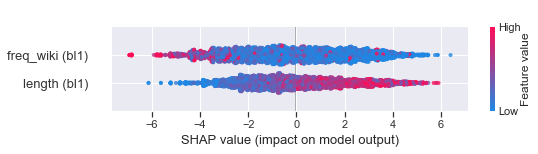

In [97]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_sumary_baseline1_bar.png', dpi=900)

In [ ]:
train = remove_labels_for_binary_df(dataset_fc_baseline_1[dataset_index].train)
train = train.loc[:, train.columns != 'log_freq_wiki']
test = remove_labels_for_binary_df(dataset_fc_baseline_1[dataset_index].test)
test = test.loc[:, test.columns != 'log_freq_wiki']
results, bst = random_forest_with_forest(*transform_feat_to_num(train, test), label='binary')

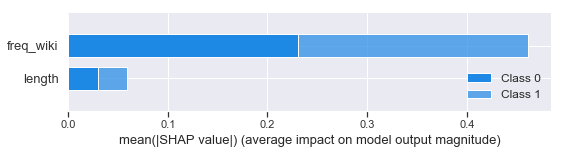

In [94]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_sumary_baseline1_rf.png', dpi=900)

### (2.1.1) Baseline II SHAP values

In [ ]:
train = remove_labels_for_binary_df(dataset_fc_baseline_2[dataset_index].train)
train = train.loc[:, train.columns != 'log_freq_wiki (bl2)']
test = remove_labels_for_binary_df(dataset_fc_baseline_2[dataset_index].test)
test = test.loc[:, test.columns != 'log_freq_wiki (bl2)']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

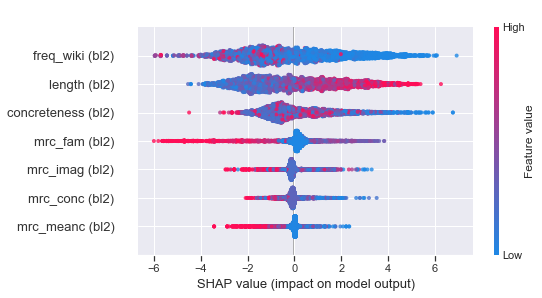

In [99]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_sumary_baseline2.png', dpi=900)

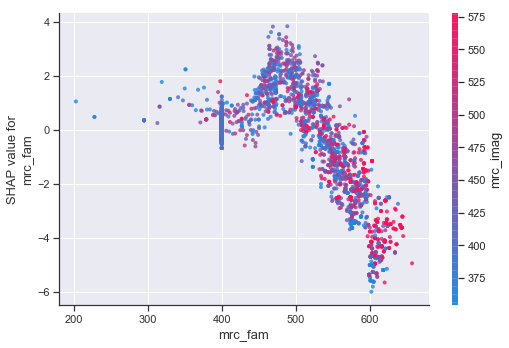

In [192]:
fig = shap.dependence_plot('mrc_fam', shap_values, x_train, interaction_index=4, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_dependency_baseline2.png', dpi=900)

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5551 samples in 0.007s...
[t-SNE] Computed neighbors for 5551 samples in 0.217s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5551
[t-SNE] Computed conditional probabilities for sample 2000 / 5551
[t-SNE] Computed conditional probabilities for sample 3000 / 5551
[t-SNE] Computed conditional probabilities for sample 4000 / 5551
[t-SNE] Computed conditional probabilities for sample 5000 / 5551
[t-SNE] Computed conditional probabilities for sample 5551 / 5551
[t-SNE] Mean sigma: 27.596046
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.453003
[t-SNE] Error after 1000 iterations: 0.201677


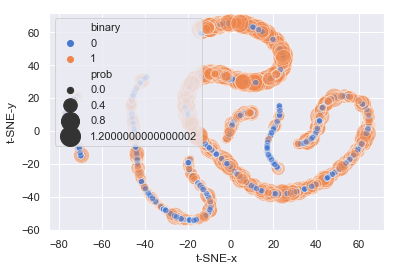

<Figure size 432x288 with 0 Axes>

In [238]:
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne/t_sne_baseline2.pdf')

### (2.1.3) Linguistic SHAP values

In [ ]:
train = remove_labels_for_binary_df(dataset_fc_linguistic[dataset_index].train)
train = train.loc[:, train.columns != 'dep_relation_to_head']
test = remove_labels_for_binary_df(dataset_fc_linguistic[dataset_index].test)
test = test.loc[:, test.columns != 'dep_relation_to_head']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

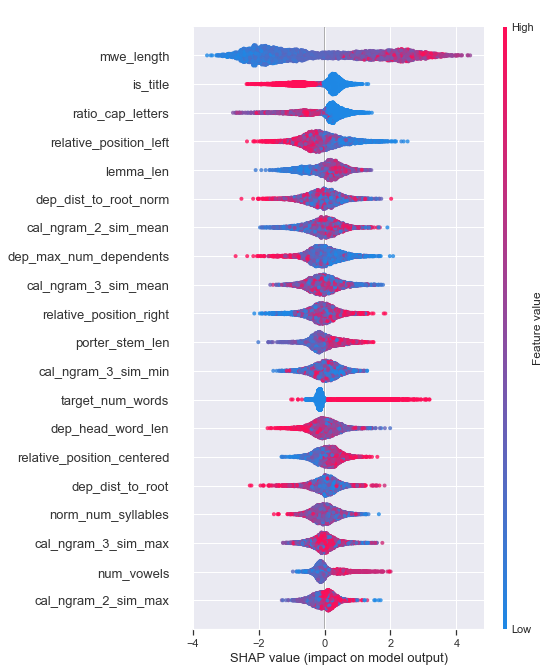

In [270]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_linguistic.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


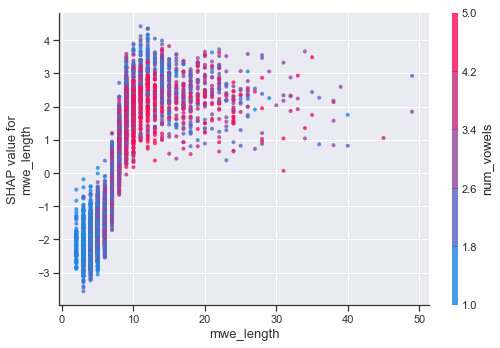

In [272]:
fig = shap.dependence_plot('mwe_length', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_dependency_linguistic_mwe_length_vowels.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


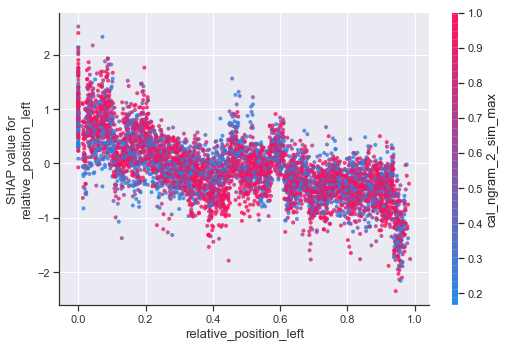

In [279]:
fig = shap.dependence_plot('relative_position_left', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_dependency_linguistic_rel_pos.png', dpi=900)

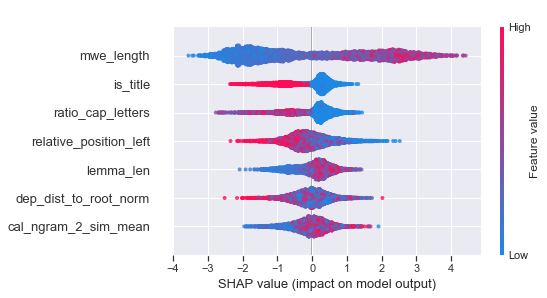

In [186]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, max_display=7, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_linguistic_small.png', dpi=900)

In [ ]:
cols = ['ratio_non_alpha', 'grapheme_to_phoneme_ratio','num_pronounciations','hyphenated', \
        'reduction_lemma_len', 'vowel_consonant_ratio', 'porter_stem_len', 'porter_stemmer_num_steps','binary']
train = remove_labels_for_binary_df(dataset_fc_linguistic[dataset_index].train)
train = train.loc[:, cols]
test = remove_labels_for_binary_df(dataset_fc_linguistic[dataset_index].test)
test = test.loc[:, cols]
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

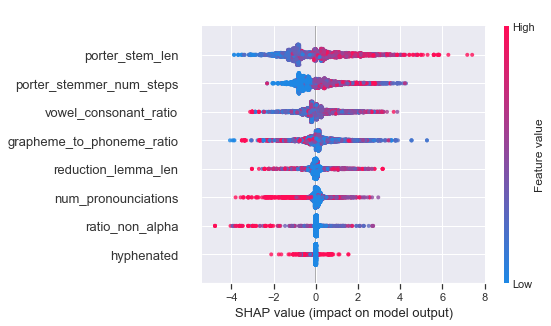

In [281]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_linguistic2.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


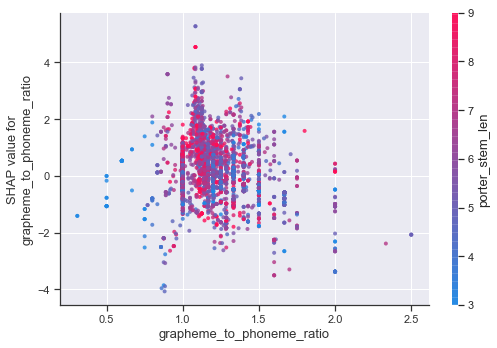

In [285]:
fig = shap.dependence_plot('grapheme_to_phoneme_ratio', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_dependency_linguistic_graph.png', dpi=900)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5551 samples in 0.104s...
[t-SNE] Computed neighbors for 5551 samples in 0.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5551
[t-SNE] Computed conditional probabilities for sample 2000 / 5551
[t-SNE] Computed conditional probabilities for sample 3000 / 5551
[t-SNE] Computed conditional probabilities for sample 4000 / 5551
[t-SNE] Computed conditional probabilities for sample 5000 / 5551
[t-SNE] Computed conditional probabilities for sample 5551 / 5551
[t-SNE] Mean sigma: 8.335950
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.343395
[t-SNE] Error after 1000 iterations: 0.441575


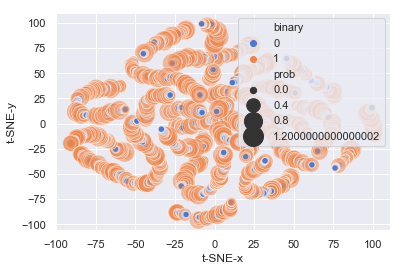

<Figure size 432x288 with 0 Axes>

In [256]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000)
train['all_caps'] = train['all_caps'].apply(lambda val : int(val))
train['is_title'] = train['is_title'].apply(lambda val : int(val))
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne/t_sne_linguistic.pdf')

### (2.1.4) Psycholingustic SHAP values

In [ ]:
#dataset = concat_feature_datasets(dataset_fc_psycholinguistic, dataset_fc_baseline_1)
dataset = dataset_fc_psycholinguistic
train = remove_labels_for_binary_df(dataset[dataset_index].train)
#train = train.loc[:, train.columns != 'dep_relation_to_head']
test = remove_labels_for_binary_df(dataset[dataset_index].test)
#test = test.loc[:, test.columns != 'dep_relation_to_head']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

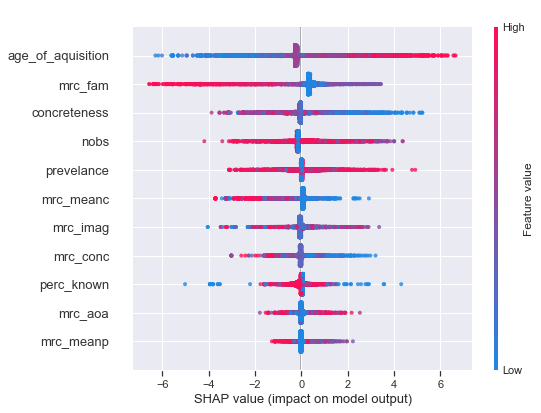

In [287]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_psycho.png', dpi=900)

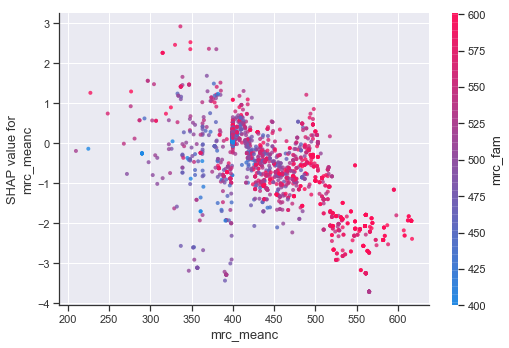

In [292]:
fig = shap.dependence_plot('mrc_meanc', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_dependency_psycho.png', dpi=900)

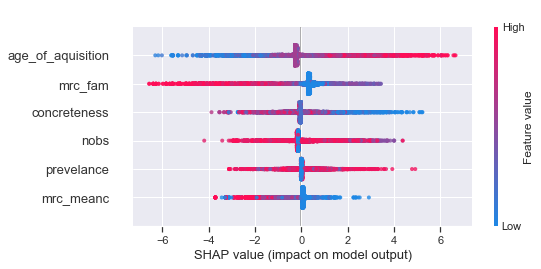

In [209]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=6)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_psycho_small.png', dpi=900)

### (2.1.5) Semantic SHAP values

In [ ]:
train = remove_labels_for_binary_df(dataset_fc_semantic[dataset_index].train)
train = train.loc[:, train.columns != 'dbp_type_00']
train = train.loc[:, train.columns != 'dbp_type_25']
train = train.loc[:, train.columns != 'swn_avg_objective_score']
test = remove_labels_for_binary_df(dataset_fc_semantic[dataset_index].test)
test = test.loc[:, test.columns != 'dbp_type_00']
test = test.loc[:, test.columns != 'dbp_type_25']
test = test.loc[:, test.columns != 'swn_avg_objective_score']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

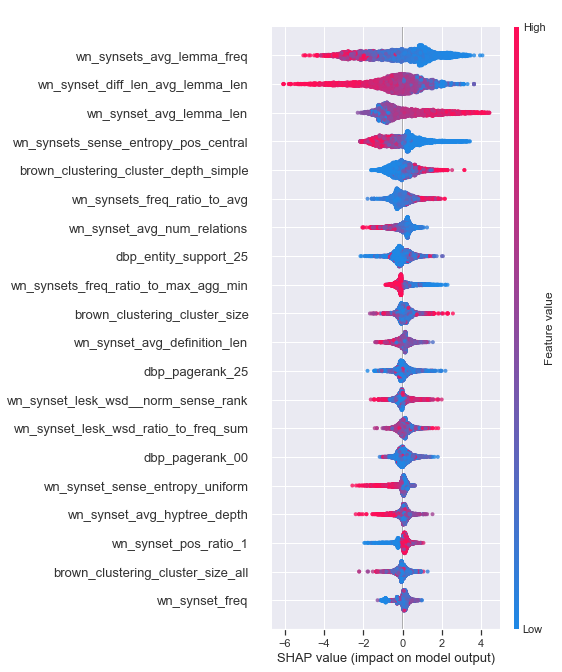

In [294]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_semantic.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


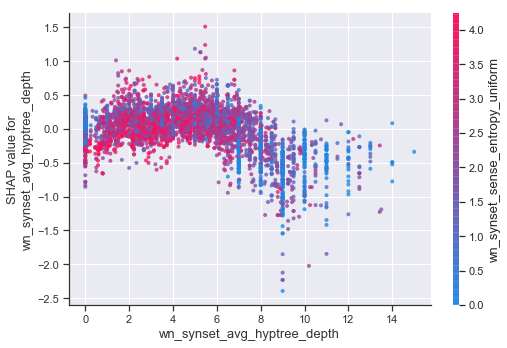

In [301]:
fig = shap.dependence_plot('wn_synset_avg_hyptree_depth', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_dependency_semantic.png', dpi=900)

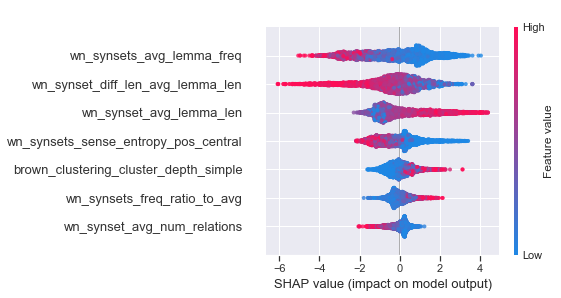

In [216]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=7)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_semantic_small.png', dpi=900)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5551 samples in 0.020s...
[t-SNE] Computed neighbors for 5551 samples in 0.801s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5551
[t-SNE] Computed conditional probabilities for sample 2000 / 5551
[t-SNE] Computed conditional probabilities for sample 3000 / 5551
[t-SNE] Computed conditional probabilities for sample 4000 / 5551
[t-SNE] Computed conditional probabilities for sample 5000 / 5551
[t-SNE] Computed conditional probabilities for sample 5551 / 5551
[t-SNE] Mean sigma: 6.002378
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.585541
[t-SNE] Error after 1000 iterations: 0.471512


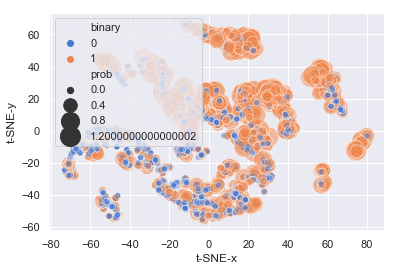

<Figure size 432x288 with 0 Axes>

In [261]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
#train['all_caps'] = train['all_caps'].apply(lambda val : int(val))
#train['is_title'] = train['is_title'].apply(lambda val : int(val))
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne/t_sne_semantic.pdf')

### (2.1.6) Corpus SHAP values

In [ ]:
train = remove_labels_for_binary_df(dataset_fc_corpus[dataset_index].train)
#train = train.loc[:, train.columns != 'dbp_type_00']
#train = train.loc[:, train.columns != 'dbp_type_25']
test = remove_labels_for_binary_df(dataset_fc_corpus[dataset_index].test)
#test = test.loc[:, test.columns != 'dbp_type_00']
#test = test.loc[:, test.columns != 'dbp_type_25']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

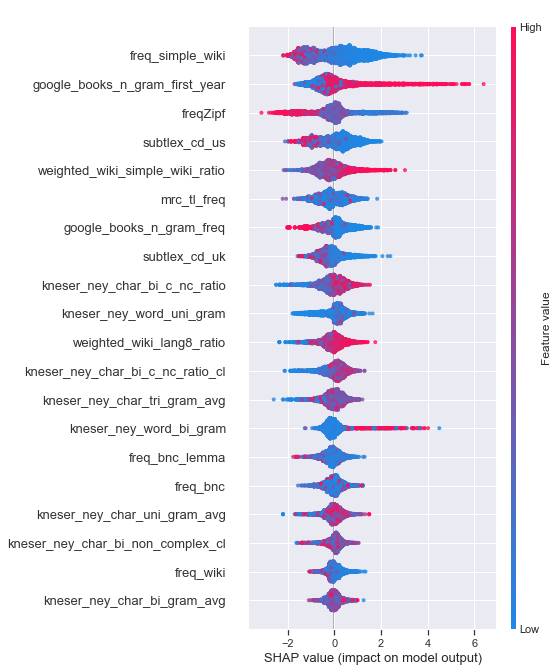

In [303]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_corpus.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:102: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:3184: R

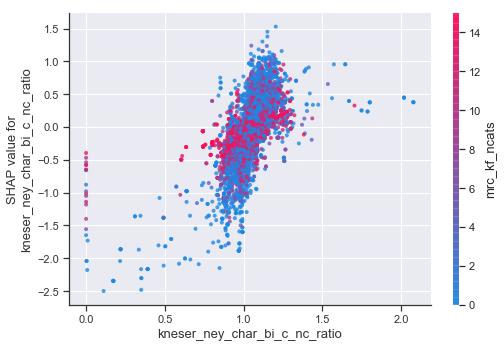

In [313]:
fig = shap.dependence_plot('kneser_ney_char_bi_c_nc_ratio', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_dependency_corpus_kn_c_nc.png', dpi=900)

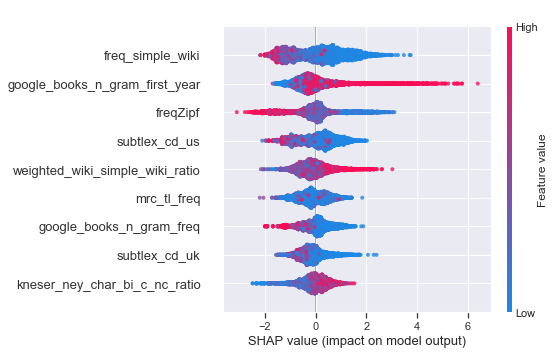

In [220]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=9)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_corpus_small.png', dpi=900)

C:\Users\Studio\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5551 samples in 0.015s...
[t-SNE] Computed neighbors for 5551 samples in 1.500s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5551
[t-SNE] Computed conditional probabilities for sample 2000 / 5551
[t-SNE] Computed conditional probabilities for sample 3000 / 5551
[t-SNE] Computed conditional probabilities for sample 4000 / 5551
[t-SNE] Computed conditional probabilities for sample 5000 / 5551
[t-SNE] Computed conditional probabilities for sample 5551 / 5551
[t-SNE] Mean sigma: 102.102320
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.903168
[t-SNE] Error after 1000 iterations: 0.299982


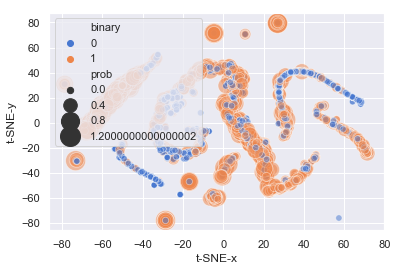

<Figure size 432x288 with 0 Axes>

In [263]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
#train['all_caps'] = train['all_caps'].apply(lambda val : int(val))
#train['is_title'] = train['is_title'].apply(lambda val : int(val))
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne/t_sne_corpus.pdf')

### (2.1.7) Dictionary SHAP values

In [ ]:
train = remove_labels_for_binary_df(dataset_fc_dictionary[dataset_index].train)
#train = train.loc[:, train.columns != 'dbp_type_00']
#train = train.loc[:, train.columns != 'dbp_type_25']
test = remove_labels_for_binary_df(dataset_fc_dictionary[dataset_index].test)
#test = test.loc[:, test.columns != 'dbp_type_00']
#test = test.loc[:, test.columns != 'dbp_type_25']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

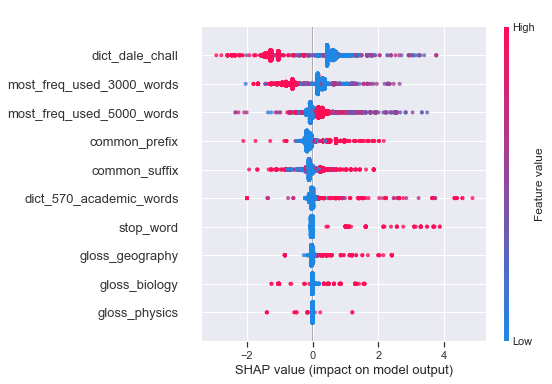

In [315]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_dictionary.png', dpi=900)

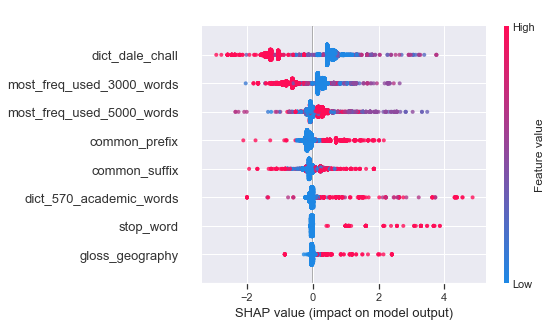

In [225]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha, max_display=8)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_dictionary_small.png', dpi=900)

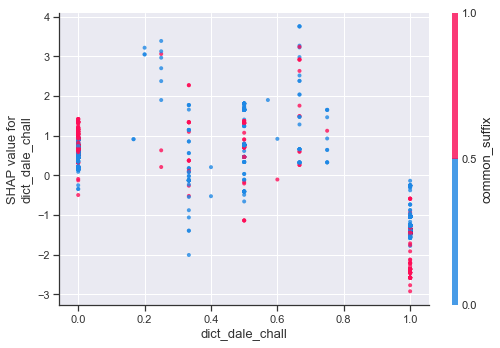

In [320]:
fig = shap.dependence_plot('dict_dale_chall', shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_dependency_dictionary.png', dpi=900)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
#train['all_caps'] = train['all_caps'].apply(lambda val : int(val))
#train['is_title'] = train['is_title'].apply(lambda val : int(val))
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne/t_sne_dictionary.pdf')

## (2.1.8) Final Feature Set SHAP values

In [ ]:
train = remove_labels_for_binary_df(dataset_fc_all[dataset_index].train)
train = train.loc[:, train.columns != 'dbp_type_00']
train = train.loc[:, train.columns != 'dbp_type_25']
train = train.loc[:, train.columns != 'swn_avg_objective_score']
train = train.loc[:, train.columns != 'relative_position_centered']
train = train.loc[:, train.columns != 'relative_position_right']
test = remove_labels_for_binary_df(dataset_fc_all[dataset_index].test)
test = test.loc[:, test.columns != 'dbp_type_00']
test = test.loc[:, test.columns != 'dbp_type_25']
test = test.loc[:, test.columns != 'swn_avg_objective_score']
test = test.loc[:, test.columns != 'relative_position_centered']
test = test.loc[:, test.columns != 'relative_position_right']
results, bst = xgboost_with_bst(*transform_feat_to_num(train, test), silent=False)

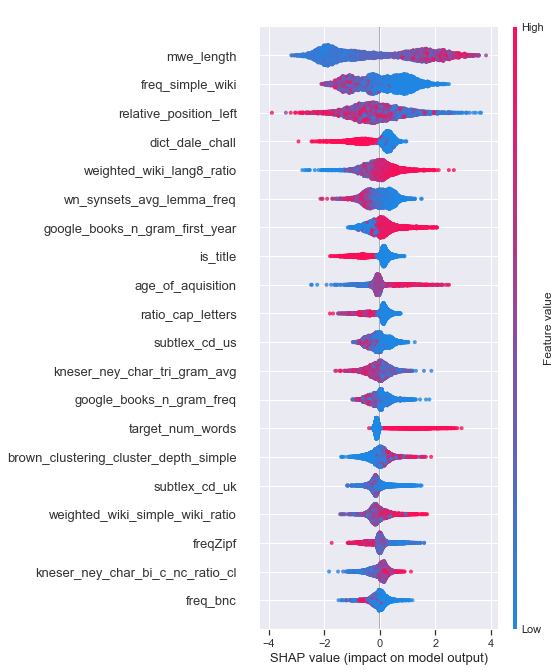

In [112]:
explainer = shap.TreeExplainer(bst)
x_train = train.loc[:, train.columns != 'binary']
shap_values = explainer.shap_values(x_train)

fig = shap.summary_plot(shap_values, x_train, show=False, alpha=alpha)
plt.tight_layout()
plt.savefig('../plots/features/shap/shap_summary_all.png', dpi=900)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5551 samples in 0.044s...
[t-SNE] Computed neighbors for 5551 samples in 1.463s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5551
[t-SNE] Computed conditional probabilities for sample 2000 / 5551
[t-SNE] Computed conditional probabilities for sample 3000 / 5551
[t-SNE] Computed conditional probabilities for sample 4000 / 5551
[t-SNE] Computed conditional probabilities for sample 5000 / 5551
[t-SNE] Computed conditional probabilities for sample 5551 / 5551
[t-SNE] Mean sigma: 45.524767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.157436
[t-SNE] Error after 1000 iterations: 0.438103


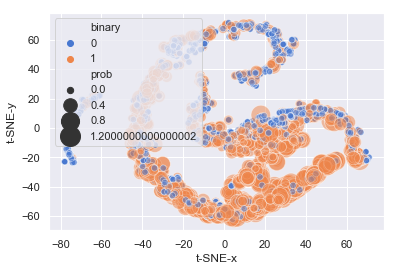

<Figure size 432x288 with 0 Axes>

In [110]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
#train['all_caps'] = train['all_caps'].apply(lambda val : int(val))
#train['is_title'] = train['is_title'].apply(lambda val : int(val))
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
tsne_results = tsne.fit_transform(train.values)
dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
train_data = datasets[dataset_index].train
dataset['binary'] = train_data['binary']
dataset['prob'] = train_data['prob']

complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=dataset)
plt.show(complexity_plot_1)
plt.tight_layout()
fig = complexity_plot_1.get_figure()
fig.savefig('../plots/features/t-sne/t_sne_all.pdf')

# Misc

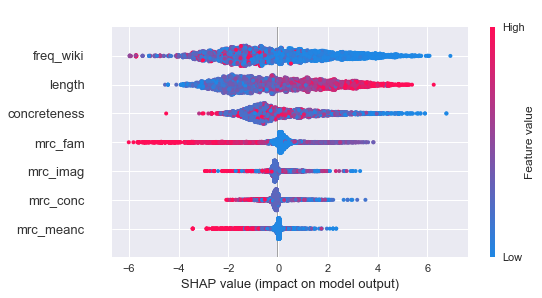

In [61]:
import seaborn as sns
sns.set()
fig = shap.summary_plot(shap_values, x_train, show=False)
plt.tight_layout()
plt.savefig('shap.png', dpi=900)

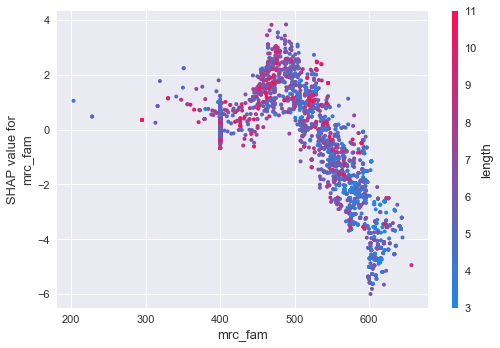

In [70]:
import seaborn as sns
sns.set()
fig = shap.dependence_plot('mrc_fam', shap_values, x_train, interaction_index=0, show=False)
plt.tight_layout()
plt.savefig('shap_dependency.png', dpi=900)

# Misc

In [ ]:
pd.options.display.max_colwidth = 200
df_trans = df.loc[df.length < 5, ["sentence", "target", "binary"]]
df_trans.loc[df_trans.binary == 1]

In [ ]:
group = df.loc[:,['target', 'binary']].groupby(['target'], as_index=False)
grouped = group.filter(lambda x : (x['binary'].mean() > 0) & (x['binary'].mean() < 1))
targets = grouped['target'].unique()
targets

In [ ]:
df.loc[df['target'] == 'major',['target', 'binary', 'id','sentence', 'ctx_length']]

In [132]:
from textatistic import Textatistic

In [158]:
import requests
from lxml import html

page = requests.get('http://sentence.yourdictionary.com/cheap')
tree = html.fromstring(page.content)
sentences = tree.xpath("//div[@class='li_content']/text()")

for sentence in sentences:
    print(sentence)

Her words sounded 
, even to her ears.
I feel 
 and... insignificant.
There was no such thing as a 
 painting by Andy Gordon.
We're in adjoining rooms at a 
 motel that's not noted for its sound insulation.
Why don't you rent one or buy a 
 one to let him try it out?
And they are so 
 as to nearly be free.
The construction of numerous unremunerative lines, and the free granting of concessions to government and other employees (and also of 
 tickets on special occasions for congresses, &c., in various towns, without strict inquiry into the qualifications of the claimants) will account for the failure to realize a higher profit.
Besides, if you buy a 
 one, you get discouraged when you can't get the quality of music that you want.
They're too 
 to let the lawyers do all the work so they had to come out here.
I should have known that all you wanted was a 
 fling.
Money order cards are very convenient and 
 (up to 10 lire for bc. short private message can be written on them.
It wasn't a 
 

In [159]:
sentences = [word for sentence in sentences for word in word_tokenize(sentence) if word.strip().lower() not in stop_words]
sentences = sentences[0:20]

In [160]:
Textatistic(' '.join(sentences) + '.').fleschkincaid_score

3.339047619047623

In [1]:
import requests
from lxml import html

page = requests.get('https://prowritingaid.com/en/Collocation/Dictionary?word=Coffee')
tree = html.fromstring(page.content)
sentences = tree.xpath("//a[@class='pwa-link']/text()")

for sentence in sentences:
    print(sentence)

table
cup
shop
mug
down
look
hand
two
back
like
machine
pot
front
sat
tea
get
make
took
down
over
pot
black
like
want
two
hot
will
made
back
went
table
cup
down
shop
get
took
over
pot
two
like
make
back
mug
will
look
black
made
hot
can
went
want
hand
room
sugar
put
morning
just
sat
front
after
cup
tea
table
pot
sugar
shop
house
cups
cocoa
houses
mug
cotton
morning
room
milk
cup
tea
sugar
shop
house
table
cocoa
pot
mug
tobacco
cotton
bread
room
plantation
juice
chocolate
morning
banana
milk
alcohol
fruit
bean
break
hand
breakfast
bacon
rubber
restaurant
rice
sandwich
be
sip
drink
have
make
take
will
bring
'll
set
order
's
sit
serve
get
want
pour
finish
can
brew
steam
go
come
put
offer
use
buy
meet
carry
do
much
empty
black
hot
second
More
such
first
long
strong
own
many
instant
half
good
low
third
fresh
local
endless
little
fourth
cold
hard
high
nice
decent
large
public
well
then
not
when
just
down
Just
only
together
much
too
now
very
daily
where
instead
there
late
back
away
maybe
here


In [ ]:
df.loc[df['sentence'].str.contains('although'),['target', 'sentence', 'binary']]

In [ ]:
df['ctx_length'] = df.sentence.apply(lambda sent : np.mean([len(t) for t in sent.split()]))
df['ctx_target_length_dev'] = df.length - df.ctx_length
df.loc[:,['target', 'length', 'ctx_length', 'ctx_target_length_dev', 'binary','sentence']]
grouped = df.loc[:,['sentence', 'binary', 'ctx_length']].groupby('sentence').agg(['sum']).eval('Col4 = Col2 / Col3')
grouped

In [ ]:
df.loc[(df['ctx_target_length_dev'] > 2) & (df['binary'] == 0),['id','target', 'sentence', 'binary', 'ctx_target_length_dev']]

In [ ]:
wordNetLemmatizer = WordNetLemmatizer()
print(wordNetLemmatizer.lemmatize("written", 'v'))

In [ ]:
from whoosh.index import create_in
from whoosh.fields import *
schema = Schema(title=TEXT(stored=True), path=ID(stored=True), content=TEXT)
ix = create_in("indexdir", schema)
writer = ix.writer()
writer.add_document(title=u"First document", path=u"/a", \
                    content=u"This is the first document we've added!")
writer.add_document(title=u"Second document", path=u"/b",\
                     content=u"The second one is even more interesting!")
writer.commit()
from whoosh.qparser import QueryParser
with ix.searcher() as searcher:
    query = QueryParser("content", ix.schema).parse("first")
    results = searcher.search(query)
    results[0]
        
{"title": u"First document", "path": u"/a"}

In [ ]:
from sklearn.manifold import TSNE

n_sne = 700

train = ctx_datasets_fc_context_complexity[0].train
data = train.loc[:, train.columns[20:].values]
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(data.values)

dataset = pd.DataFrame(tsne_results, columns=['t-SNE-x', 't-SNE-y'])
dataset['binary'] = train['binary']
dataset['prob'] = train['prob']

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = dataset
complexity_plot_1 = sns.scatterplot(x="t-SNE-x", y="t-SNE-y", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot_1)

In [ ]:
df.loc[df['target'] == 'covered',['target', 'sentence', 'wn_synset_lesk_wsd__norm_sense_rank']]